In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30
X, y = create_sequences(scaled_residuals, seq_length)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :]) 
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 20
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):  # Corrected line
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold=35):
    # If no predicted values are provided, use the threshold to detect anomalies
    if predicted_values is None:
        anomalies = np.abs(temperature_values) > threshold  # Detect anomalies over 35°C by default
    else:
        # Detect anomalies based on deviation from predicted values
        anomalies = np.abs(temperature_values - predicted_values) > threshold
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        # Convert last timestamp to ISO 8601 string
        last_timestamp_iso = last_timestamp.isoformat()

        # Use string-based comparison for ISO 8601 timestamps
        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    # Convert the response to a DataFrame
    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    # Convert columns to appropriate data types
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')

        # Convert 'timestamp' from ISO 8601 string to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

        # Drop rows with invalid temperature or humidity values
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")

    return df

def process_realtime_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        # Fetch real-time data from DynamoDB
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            # Update last timestamp to fetch new data in the next iteration
            last_timestamp = real_time_data['timestamp'].max()

            # Use the temperature data directly for anomaly detection
            real_time_temperatures = real_time_data['temperature'].values
            
            # Detect anomalies based on the threshold (e.g., > 35°C)
            anomalies = detect_anomalies(real_time_temperatures, threshold=35)

            if np.any(anomalies):
                print(f"Detected Anomalies at {real_time_data['timestamp'][anomalies]}")
                print(real_time_data.iloc[anomalies])
            else:
                print("No anomalies detected.")
        else:
            print("No new real-time data available.")

        # Sleep before the next fetch (for simulation purposes)
        time.sleep(60)

# Start real-time processing
process_realtime_data()


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely

Epoch 1/20, Loss: 0.0020885691046714783
Epoch 2/20, Loss: 0.002043720567598939
Epoch 3/20, Loss: 0.0011775812599807978
Epoch 4/20, Loss: 0.004463885445147753
Epoch 5/20, Loss: 0.0019639581441879272
Epoch 6/20, Loss: 0.0015490571968257427
Epoch 7/20, Loss: 0.0011822645319625735
Epoch 8/20, Loss: 0.0017602965235710144
Epoch 9/20, Loss: 0.005837987642735243
Epoch 10/20, Loss: 0.00034931307891383767
Epoch 11/20, Loss: 0.002657464938238263
Epoch 12/20, Loss: 0.0014651031233370304
Epoch 13/20, Loss: 0.003972743637859821
Epoch 14/20, Loss: 0.001958999549970031
Epoch 15/20, Loss: 0.0029588681645691395
Epoch 16/20, Loss: 0.0018155074212700129
Epoch 17/20, Loss: 0.0012836487730965018
Epoch 18/20, Loss: 0.00212760828435421
Epoch 19/20, Loss: 0.004209465812891722
Epoch 20/20, Loss: 0.002270556753501296
Real-time data fetched and preprocessed:
   humidity sensor_id  temperature           timestamp
0      60.0   sensor1         25.6 2024-08-30 14:46:26
1      60.0   sensor1         25.6 2024-08-30 1

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Loc

Epoch 1/100, Loss: 0.002955110976472497
Epoch 2/100, Loss: 0.0028237137012183666
Epoch 3/100, Loss: 0.002541664522141218
Epoch 4/100, Loss: 0.0016426914371550083
Epoch 5/100, Loss: 0.001257250551134348
Epoch 6/100, Loss: 0.00137809116858989
Epoch 7/100, Loss: 0.004989337176084518
Epoch 8/100, Loss: 0.0025061913765966892
Epoch 9/100, Loss: 0.00518595427274704
Epoch 10/100, Loss: 0.006675769109278917
Epoch 11/100, Loss: 0.0010627454612404108
Epoch 12/100, Loss: 0.0021779839880764484
Epoch 13/100, Loss: 0.004837979096919298
Epoch 14/100, Loss: 0.0031935060396790504
Epoch 15/100, Loss: 0.0026193077210336924
Epoch 16/100, Loss: 0.0014033220941200852
Epoch 17/100, Loss: 0.0026179933920502663
Epoch 18/100, Loss: 0.003217168617993593
Epoch 19/100, Loss: 0.0037934700958430767
Epoch 20/100, Loss: 0.003709058742970228
Epoch 21/100, Loss: 0.0010092027951031923
Epoch 22/100, Loss: 0.0021086283959448338
Epoch 23/100, Loss: 0.005178432911634445
Epoch 24/100, Loss: 0.0020797308534383774
Epoch 25/100, 

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


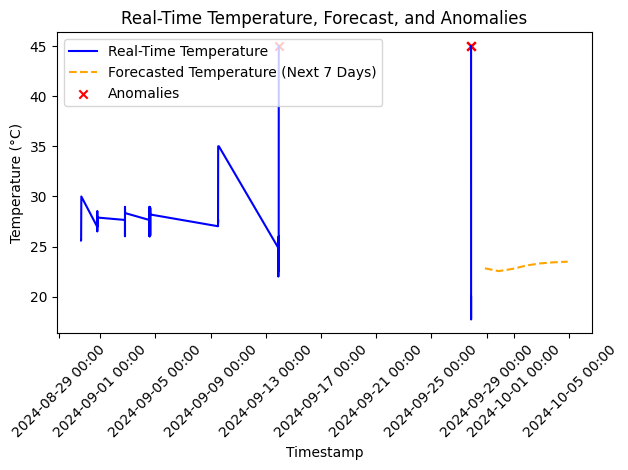

No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold=35):
    if predicted_values is None:
        anomalies = np.abs(temperature_values) > threshold
    else:
        anomalies = np.abs(temperature_values - predicted_values) > threshold
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

# Visualization and real-time prediction with weekly forecast and marked anomalies
def visualize_realtime_data(df, forecast, anomalies):
    fig, ax = plt.subplots()

    # Plot real-time temperatures
    ax.plot(df['timestamp'], df['temperature'], label='Real-Time Temperature', color='blue')

    # Plot forecasted temperatures (SARIMA forecast)
    forecast_index = pd.date_range(start=df['timestamp'].iloc[-1], periods=len(forecast)+1, freq='D')[1:]
    ax.plot(forecast_index, forecast, label='Forecasted Temperature (Next 7 Days)', linestyle='--', color='orange')

    # Mark anomalies in red crosses
    anomaly_indices = df.index[anomalies]
    ax.scatter(df['timestamp'][anomalies], df['temperature'][anomalies], color='red', marker='x', label='Anomalies')

    # Formatting the plot
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Real-Time Temperature, Forecast, and Anomalies')

    # Rotate and format the x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    
    # Add legend to the plot
    ax.legend()

    plt.tight_layout()
    plt.show()

def process_realtime_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values
            
            # Predict next 7 days temperatures using SARIMA (or LSTM if integrated)
            forecast = sarima_model_fit.forecast(steps=7)
            
            anomalies = detect_anomalies(real_time_temperatures, threshold=35)
            visualize_realtime_data(real_time_data, forecast, anomalies)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_data()


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Loc

Epoch 1/20, Loss: 0.0022139467764645815
Epoch 2/20, Loss: 0.0020639479625970125
Epoch 3/20, Loss: 0.0024492100346833467
Epoch 4/20, Loss: 0.003695472376421094
Epoch 5/20, Loss: 0.005006098188459873
Epoch 6/20, Loss: 0.0025711238849908113
Epoch 7/20, Loss: 0.0013755373656749725
Epoch 8/20, Loss: 0.0017302017658948898
Epoch 9/20, Loss: 0.0018187591340392828
Epoch 10/20, Loss: 0.0025478184688836336
Epoch 11/20, Loss: 0.0016771683003753424
Epoch 12/20, Loss: 0.0038633928634226322
Epoch 13/20, Loss: 0.001132694073021412
Epoch 14/20, Loss: 0.002725330414250493
Epoch 15/20, Loss: 0.0012927432544529438
Epoch 16/20, Loss: 0.004408893175423145
Epoch 17/20, Loss: 0.0020967074669897556
Epoch 18/20, Loss: 0.0038059435319155455
Epoch 19/20, Loss: 0.0027700429782271385
Epoch 20/20, Loss: 0.004822932183742523
Real-time data fetched and preprocessed:
   humidity sensor_id  temperature           timestamp
0      60.0   sensor1         25.6 2024-08-30 14:46:26
1      60.0   sensor1         25.6 2024-08-3

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


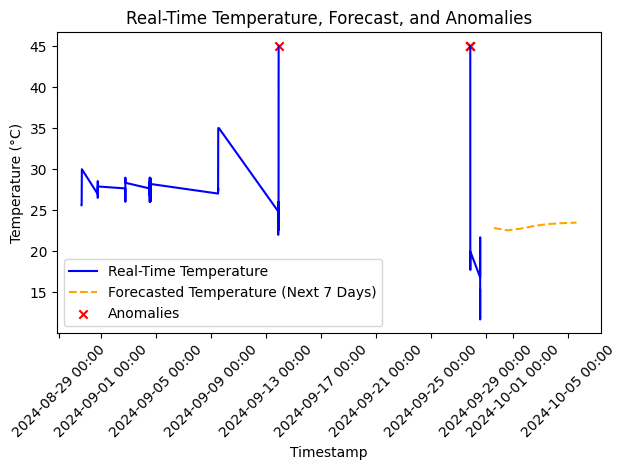

No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 20
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold=35):
    if predicted_values is None:
        anomalies = np.abs(temperature_values) > threshold
    else:
        anomalies = np.abs(temperature_values - predicted_values) > threshold
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

# Visualization and real-time prediction with weekly forecast and marked anomalies
def visualize_realtime_data(df, forecast, anomalies):
    fig, ax = plt.subplots()

    # Plot real-time temperatures
    ax.plot(df['timestamp'], df['temperature'], label='Real-Time Temperature', color='blue')

    # Plot forecasted temperatures (SARIMA forecast)
    forecast_index = pd.date_range(start=df['timestamp'].iloc[-1], periods=len(forecast)+1, freq='D')[1:]
    ax.plot(forecast_index, forecast, label='Forecasted Temperature (Next 7 Days)', linestyle='--', color='orange')

    # Mark anomalies in red crosses
    anomaly_indices = df.index[anomalies]
    ax.scatter(df['timestamp'][anomalies], df['temperature'][anomalies], color='red', marker='x', label='Anomalies')

    # Formatting the plot
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Real-Time Temperature, Forecast, and Anomalies')

    # Rotate and format the x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    
    # Add legend to the plot
    ax.legend()

    plt.tight_layout()
    plt.show()

def process_realtime_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values
            
            # Predict next 7 days temperatures using SARIMA (or LSTM if integrated)
            forecast = sarima_model_fit.forecast(steps=7)
            
            anomalies = detect_anomalies(real_time_temperatures, threshold=35)
            visualize_realtime_data(real_time_data, forecast, anomalies)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_data()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold=35):
    if predicted_values is None:
        anomalies = np.abs(temperature_values) > threshold
    else:
        anomalies = np.abs(temperature_values - predicted_values) > threshold
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

# Visualization of real-time temperature and anomalies in separate plots
def visualize_realtime_data(df, forecast, anomalies):
    # Plot 1: Real-time temperature and anomalies
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot real-time temperatures
    ax1.plot(df['timestamp'], df['temperature'], label='Real-Time Temperature', color='blue')

    # Mark anomalies in red crosses
    ax1.scatter(df['timestamp'][anomalies], df['temperature'][anomalies], color='red', marker='x', label='Anomalies')

    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Real-Time Temperature and Anomalies')

    ax1.legend()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)

    # Plot 2: Forecasted temperature (SARIMA forecast)
    forecast_index = pd.date_range(start=df['timestamp'].iloc[-1], periods=len(forecast)+1, freq='D')[1:]
    ax2.plot(forecast_index, forecast, label='Forecasted Temperature (Next 7 Days)', linestyle='--', color='orange')

    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Temperature (°C)')
    ax2.set_title('Forecasted Temperature')

    ax2.legend()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def process_realtime_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values
            
            # Predict next 7 days temperatures using SARIMA
            forecast = sarima_model_fit.forecast(steps=7)
            
            anomalies = detect_anomalies(real_time_temperatures, threshold=35)
            visualize_realtime_data(real_time_data, forecast, anomalies)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_data()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold=35):
    if predicted_values is None:
        # Detect anomalies based on a threshold, either above or below the expected range
        anomalies = (temperature_values > threshold) | (temperature_values < -threshold)
    else:
        # Detect anomalies based on significant deviations from predicted values
        anomalies = np.abs(temperature_values - predicted_values) > threshold
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

# Visualization of real-time temperature and anomalies in separate plots
def visualize_realtime_data(df, forecast, anomalies):
    # Plot 1: Real-time temperature and anomalies
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot real-time temperatures
    ax1.plot(df['timestamp'], df['temperature'], label='Real-Time Temperature', color='blue')

    # Mark anomalies in red crosses
    ax1.scatter(df['timestamp'][anomalies], df['temperature'][anomalies], color='red', marker='x', label='Anomalies')

    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Real-Time Temperature and Anomalies')

    ax1.legend()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)

    # Plot 2: Forecasted temperature (SARIMA forecast)
    forecast_index = pd.date_range(start=df['timestamp'].iloc[-1], periods=len(forecast)+1, freq='D')[1:]
    ax2.plot(forecast_index, forecast, label='Forecasted Temperature (Next 7 Days)', linestyle='--', color='orange')

    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Temperature (°C)')
    ax2.set_title('Forecasted Temperature')

    ax2.legend()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def process_realtime_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values
            
            # Predict next 7 days temperatures using SARIMA
            forecast = sarima_model_fit.forecast(steps=7)
            
            # Detect anomalies based on real-time data compared to forecast or a set threshold
            anomalies = detect_anomalies(real_time_temperatures)
            
            # Visualize the data and anomalies
            visualize_realtime_data(real_time_data, forecast, anomalies)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_data()


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Loc

Epoch 1/100, Loss: 0.0018697604537010193
Epoch 2/100, Loss: 0.0034107943065464497
Epoch 3/100, Loss: 0.005130678880959749
Epoch 4/100, Loss: 0.0025311524514108896
Epoch 5/100, Loss: 0.003312500426545739
Epoch 6/100, Loss: 0.002262829104438424
Epoch 7/100, Loss: 0.002562787849456072
Epoch 8/100, Loss: 0.002753201173618436
Epoch 9/100, Loss: 0.0024416535161435604
Epoch 10/100, Loss: 0.00196339120157063
Epoch 11/100, Loss: 0.0039041100535541773
Epoch 12/100, Loss: 0.0013616645010188222
Epoch 13/100, Loss: 0.0011738344328477979
Epoch 14/100, Loss: 0.0018805324798449874
Epoch 15/100, Loss: 0.0032077706418931484
Epoch 16/100, Loss: 0.00237923301756382
Epoch 17/100, Loss: 0.002817320404574275
Epoch 18/100, Loss: 0.0033878698013722897
Epoch 19/100, Loss: 0.002854075515642762
Epoch 20/100, Loss: 0.0021554632112383842
Epoch 21/100, Loss: 0.0036622933112084866
Epoch 22/100, Loss: 0.0021663543302565813
Epoch 23/100, Loss: 0.0037228427827358246
Epoch 24/100, Loss: 0.0028827146161347628
Epoch 25/100

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


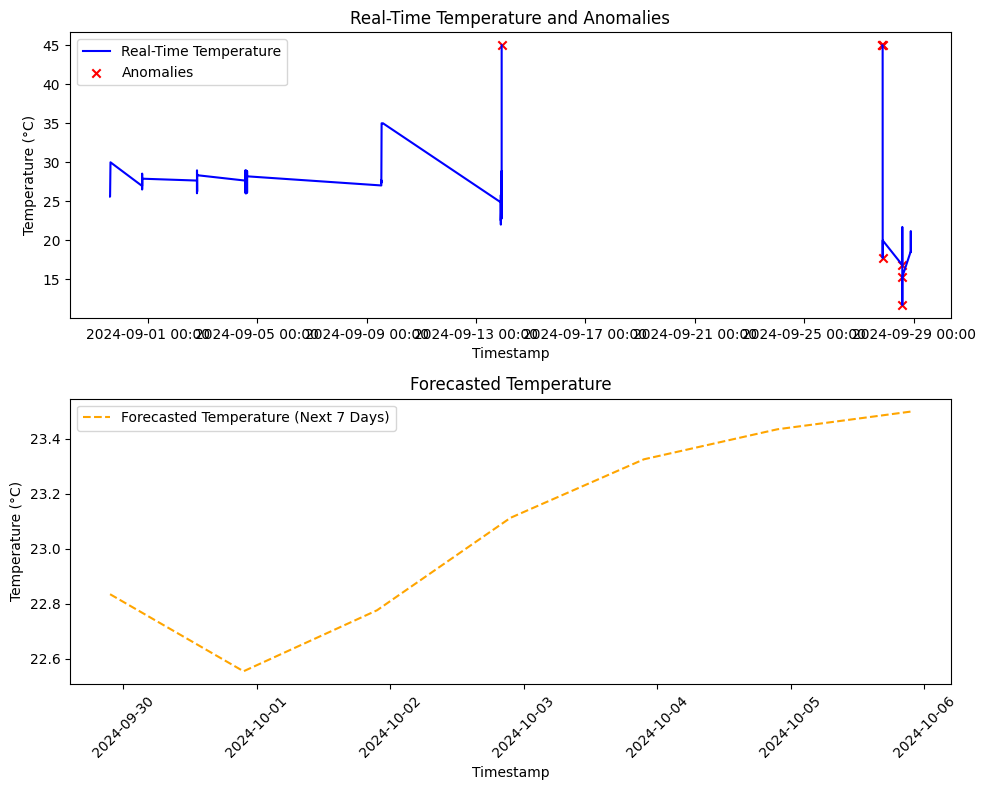

No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data fo

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold_factor=2):
    if predicted_values is None:
        # Use the standard deviation of the current temperatures to dynamically set thresholds
        mean_temp = np.mean(temperature_values)
        std_temp = np.std(temperature_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    else:
        # Detect anomalies based on significant deviations from predicted values
        mean_temp = np.mean(predicted_values)
        std_temp = np.std(predicted_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

# Visualization of real-time temperature and anomalies in separate plots
def visualize_realtime_data(df, forecast, anomalies):
    # Plot 1: Real-time temperature and anomalies
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot real-time temperatures
    ax1.plot(df['timestamp'], df['temperature'], label='Real-Time Temperature', color='blue')

    # Mark anomalies in red crosses
    ax1.scatter(df['timestamp'][anomalies], df['temperature'][anomalies], color='red', marker='x', label='Anomalies')

    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Real-Time Temperature and Anomalies')

    ax1.legend()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)

    # Plot 2: Forecasted temperature (SARIMA forecast)
    forecast_index = pd.date_range(start=df['timestamp'].iloc[-1], periods=len(forecast)+1, freq='D')[1:]
    ax2.plot(forecast_index, forecast, label='Forecasted Temperature (Next 7 Days)', linestyle='--', color='orange')

    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Temperature (°C)')
    ax2.set_title('Forecasted Temperature')

    ax2.legend()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def process_realtime_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values
            
            # Predict next 7 days temperatures using SARIMA
            forecast = sarima_model_fit.forecast(steps=7)
            
            anomalies = detect_anomalies(real_time_temperatures)
            visualize_realtime_data(real_time_data, forecast, anomalies)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_data()


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely

Epoch 1/100, Loss: 0.002097408752888441
Epoch 2/100, Loss: 0.002122388454154134
Epoch 3/100, Loss: 0.0038030084688216448
Epoch 4/100, Loss: 0.0030490662902593613
Epoch 5/100, Loss: 0.0019549038261175156
Epoch 6/100, Loss: 0.0014243721961975098
Epoch 7/100, Loss: 0.0016727560432627797
Epoch 8/100, Loss: 0.0013993033207952976
Epoch 9/100, Loss: 0.0036366505082696676
Epoch 10/100, Loss: 0.00178879767190665
Epoch 11/100, Loss: 0.002164340578019619
Epoch 12/100, Loss: 0.001354976324364543
Epoch 13/100, Loss: 0.0028140798676759005
Epoch 14/100, Loss: 0.0017407258274033666
Epoch 15/100, Loss: 0.006489000283181667
Epoch 16/100, Loss: 0.004013027064502239
Epoch 17/100, Loss: 0.0010130389127880335
Epoch 18/100, Loss: 0.002281898632645607
Epoch 19/100, Loss: 0.004016927443444729
Epoch 20/100, Loss: 0.0017918229568749666
Epoch 21/100, Loss: 0.0013723511947318912
Epoch 22/100, Loss: 0.002955704228952527
Epoch 23/100, Loss: 0.0028545763343572617
Epoch 24/100, Loss: 0.0020367149263620377
Epoch 25/100

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


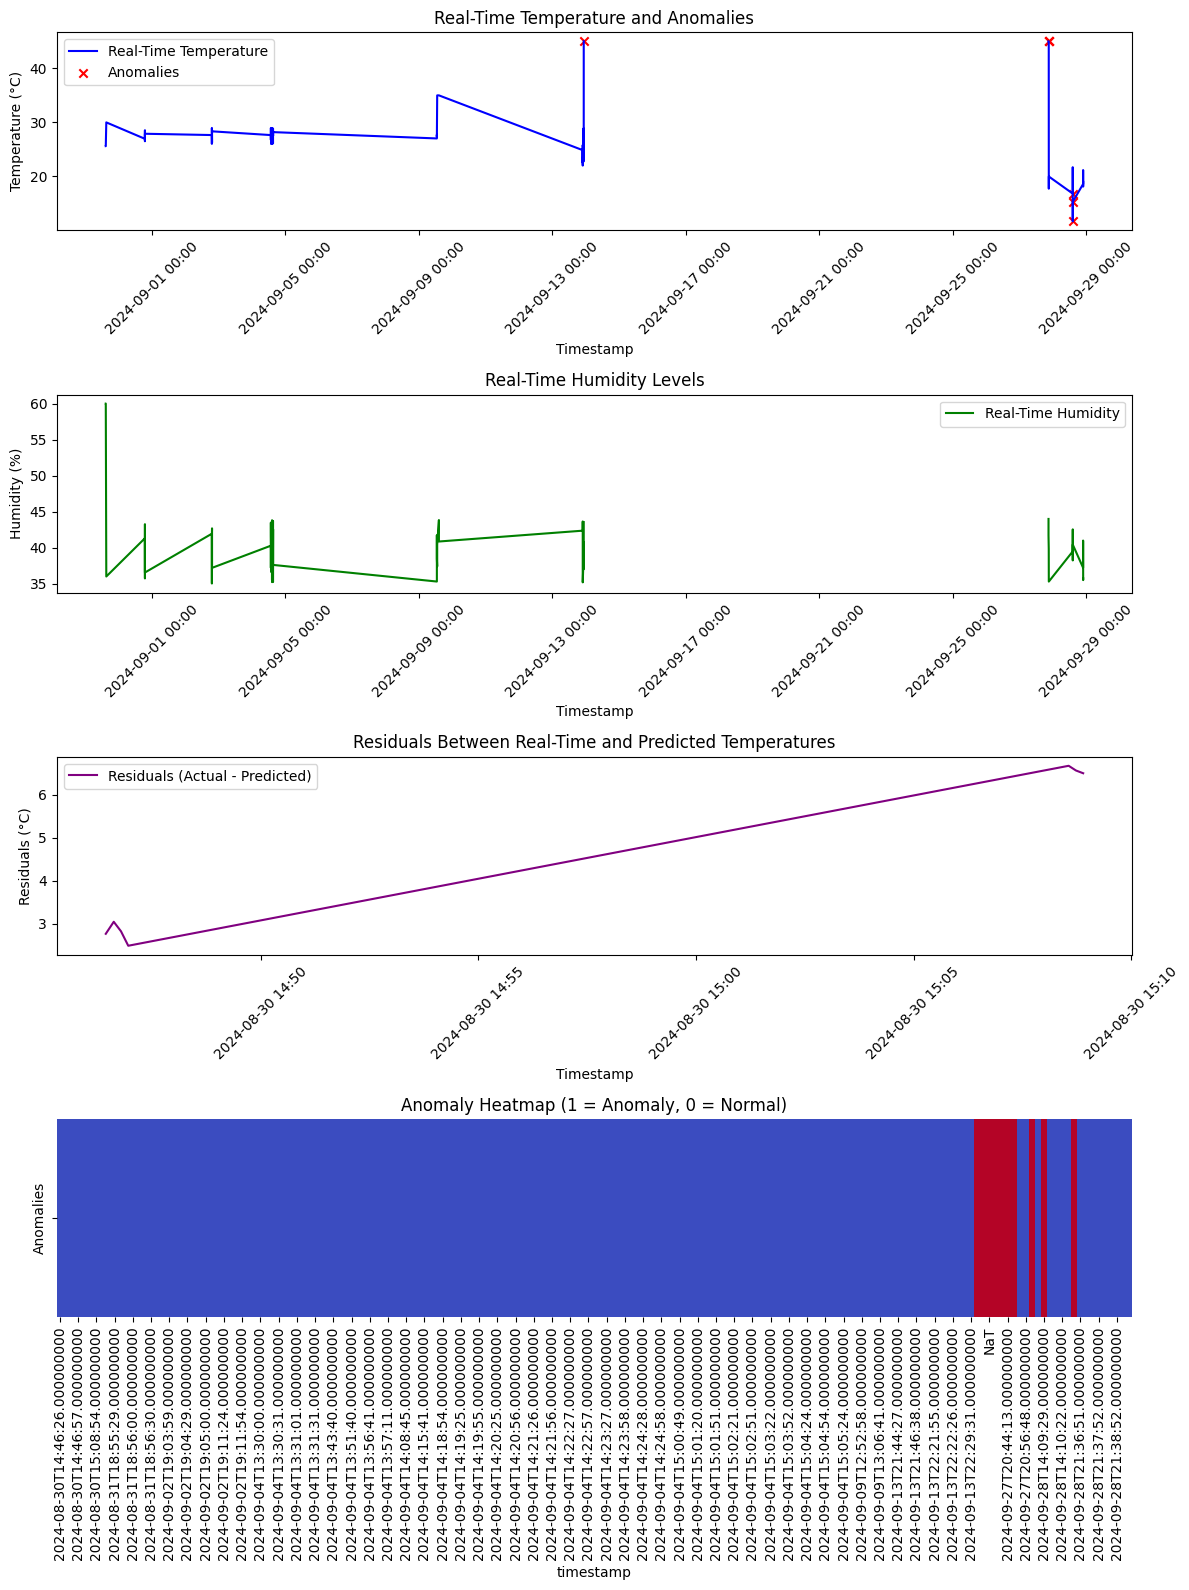

No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold_factor=2):
    if predicted_values is None:
        mean_temp = np.mean(temperature_values)
        std_temp = np.std(temperature_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    else:
        mean_temp = np.mean(predicted_values)
        std_temp = np.std(predicted_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

# Visualization of real-time temperature, humidity, residuals, and anomalies heatmap
def visualize_realtime_data(df, forecast, anomalies):
    fig, axs = plt.subplots(4, 1, figsize=(12, 16))

    # Plot 1: Real-time temperature and anomalies
    axs[0].plot(df['timestamp'], df['temperature'], label='Real-Time Temperature', color='blue')
    axs[0].scatter(df['timestamp'][anomalies], df['temperature'][anomalies], color='red', marker='x', label='Anomalies')
    axs[0].set_xlabel('Timestamp')
    axs[0].set_ylabel('Temperature (°C)')
    axs[0].set_title('Real-Time Temperature and Anomalies')
    axs[0].legend()
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[0].tick_params(axis='x', rotation=45)

    # Plot 2: Humidity levels
    axs[1].plot(df['timestamp'], df['humidity'], label='Real-Time Humidity', color='green')
    axs[1].set_xlabel('Timestamp')
    axs[1].set_ylabel('Humidity (%)')
    axs[1].set_title('Real-Time Humidity Levels')
    axs[1].legend()
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[1].tick_params(axis='x', rotation=45)

    # Plot 3: Residuals between actual and predicted temperature
    if len(forecast) >= len(df):
        forecast_shortened = forecast[:len(df)]
    else:
        forecast_shortened = forecast

    residuals = df['temperature'].values[:len(forecast_shortened)] - forecast_shortened
    axs[2].plot(df['timestamp'][:len(forecast_shortened)], residuals, label='Residuals (Actual - Predicted)', color='purple')
    axs[2].set_xlabel('Timestamp')
    axs[2].set_ylabel('Residuals (°C)')
    axs[2].set_title('Residuals Between Real-Time and Predicted Temperatures')
    axs[2].legend()
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[2].tick_params(axis='x', rotation=45)

    # Plot 4: Anomaly heatmap
    anomaly_heatmap_data = pd.DataFrame({'Anomalies': anomalies.astype(int)}, index=df['timestamp'])
    sns.heatmap(anomaly_heatmap_data.T, ax=axs[3], cmap="coolwarm", cbar=False)
    axs[3].set_title('Anomaly Heatmap (1 = Anomaly, 0 = Normal)')
    
    plt.tight_layout()
    plt.show()

def process_realtime_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values
            
            # Predict next 7 days temperatures using SARIMA
            forecast = sarima_model_fit.forecast(steps=7)
            
            anomalies = detect_anomalies(real_time_temperatures)
            visualize_realtime_data(real_time_data, forecast, anomalies)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_data()


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely

Epoch 1/100, Loss: 0.0026389206759631634
Epoch 2/100, Loss: 0.004518796689808369
Epoch 3/100, Loss: 0.001017244765534997
Epoch 4/100, Loss: 0.0014683075714856386
Epoch 5/100, Loss: 0.002651987597346306
Epoch 6/100, Loss: 0.0017395839095115662
Epoch 7/100, Loss: 0.005804397631436586
Epoch 8/100, Loss: 0.004578670021146536
Epoch 9/100, Loss: 0.0015900275902822614
Epoch 10/100, Loss: 0.0017714540008455515
Epoch 11/100, Loss: 0.0019996825139969587
Epoch 12/100, Loss: 0.0024056602269411087
Epoch 13/100, Loss: 0.0012182382633909583
Epoch 14/100, Loss: 0.002042898442596197
Epoch 15/100, Loss: 0.0012907374184578657
Epoch 16/100, Loss: 0.0027515755500644445
Epoch 17/100, Loss: 0.0006869243225082755
Epoch 18/100, Loss: 0.003176165046170354
Epoch 19/100, Loss: 0.003802037565037608
Epoch 20/100, Loss: 0.0024182505439966917
Epoch 21/100, Loss: 0.0020374697633087635
Epoch 22/100, Loss: 0.004734835587441921
Epoch 23/100, Loss: 0.002452596090734005
Epoch 24/100, Loss: 0.001881870673969388
Epoch 25/100

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Temp\ipykernel_29680\166445529.py:204: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


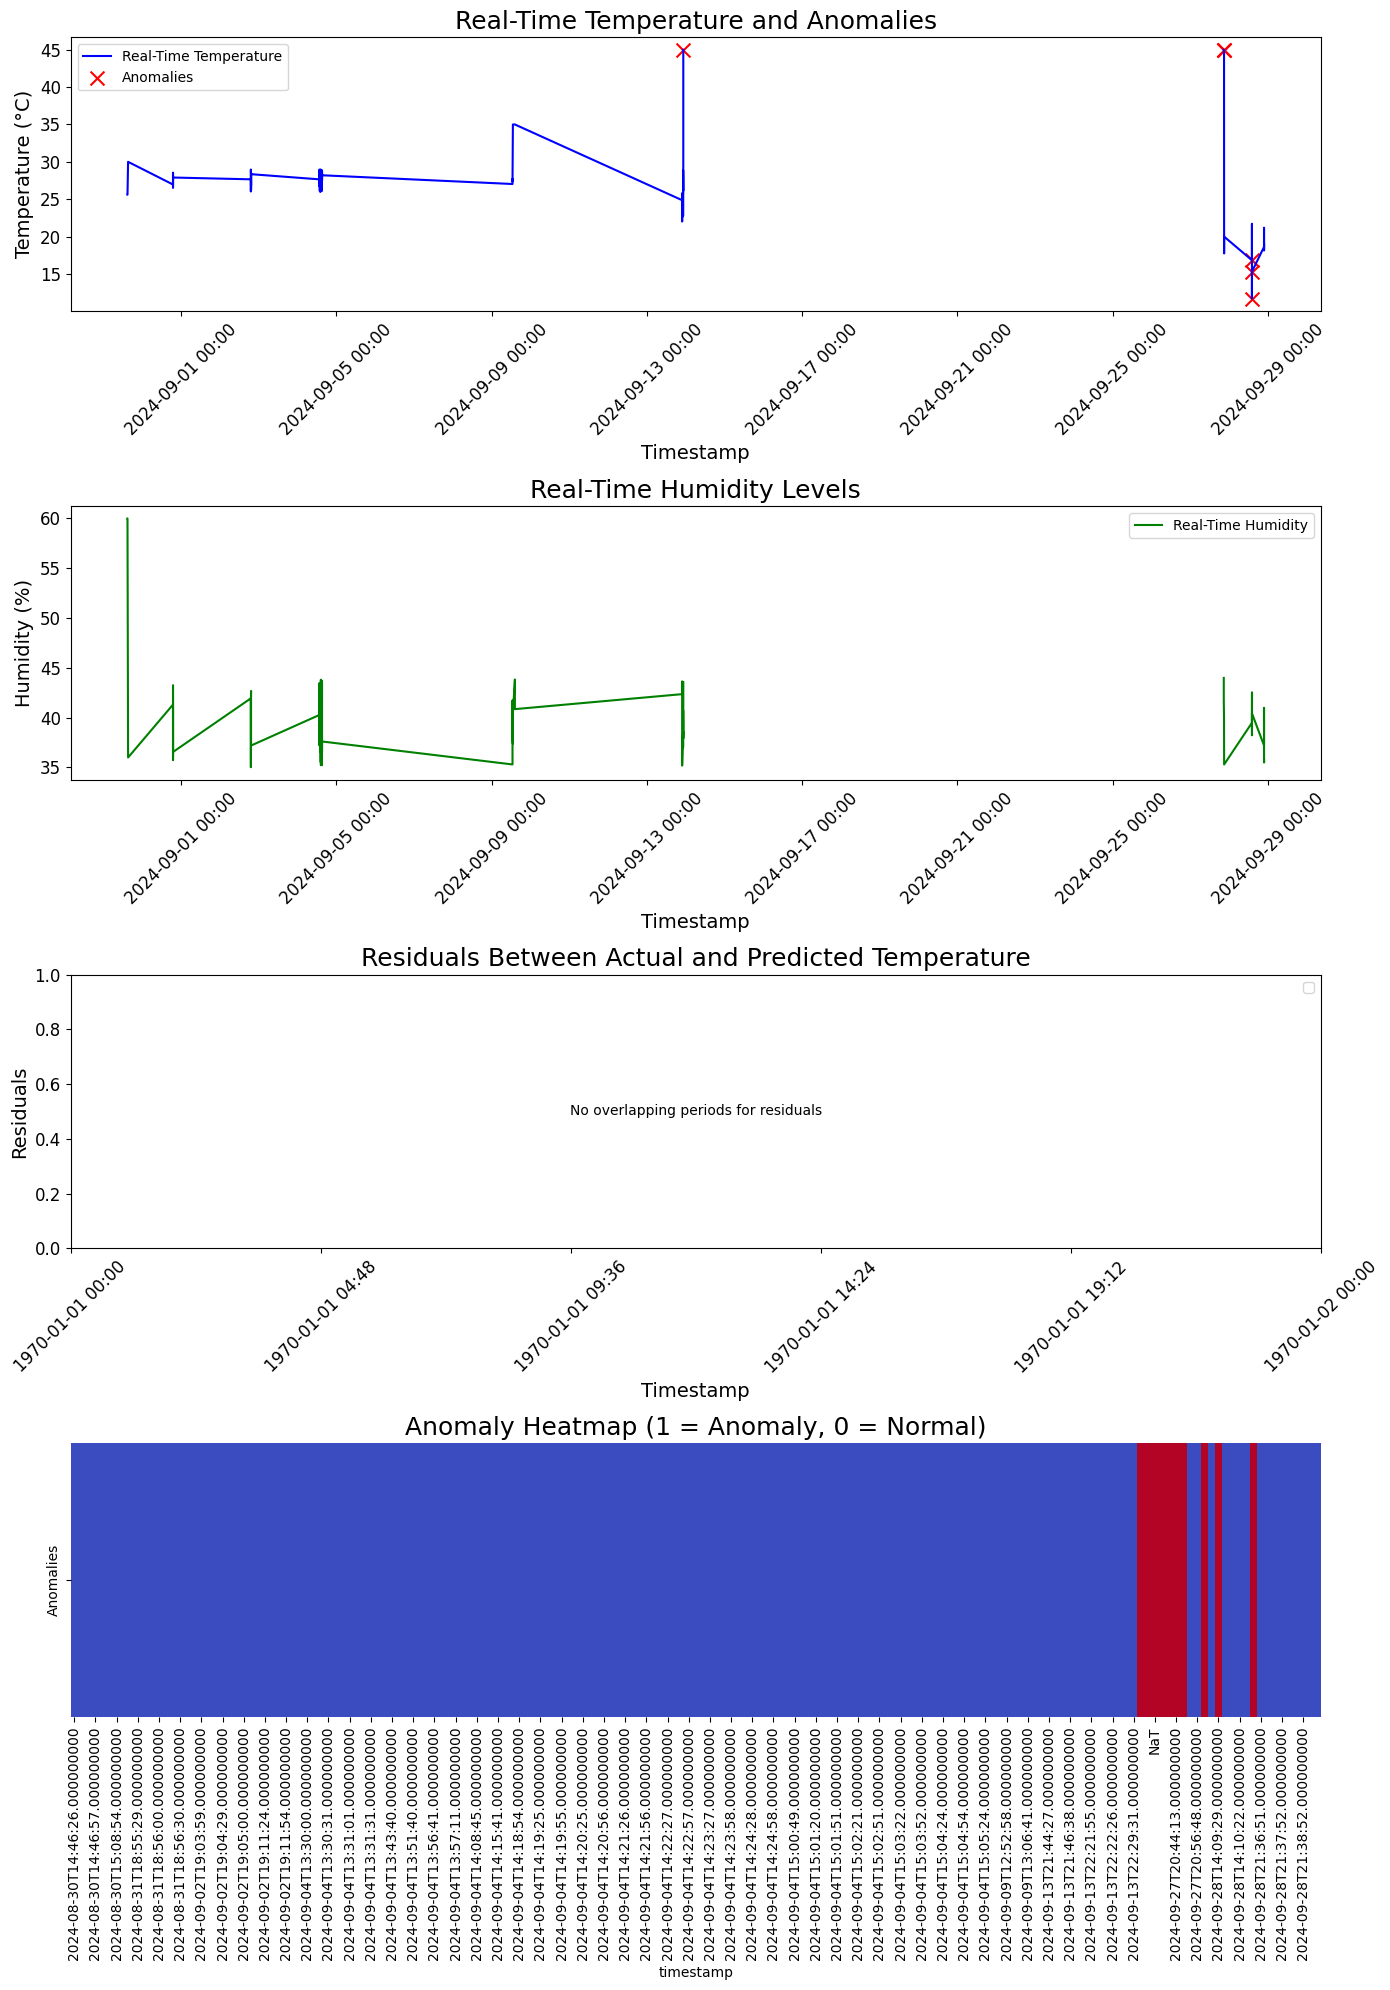

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold_factor=2):
    """Detect anomalies based on the temperature deviations from the mean or predicted values."""
    if predicted_values is None:
        mean_temp = np.mean(temperature_values)
        std_temp = np.std(temperature_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    else:
        mean_temp = np.mean(predicted_values)
        std_temp = np.std(predicted_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

def visualize_realtime_data(df, forecast, anomalies):
    # Increase the size of the plots and make texts more readable
    fig, axs = plt.subplots(4, 1, figsize=(14, 20))

    # Set common parameters for all plots
    title_fontsize = 18
    label_fontsize = 14
    tick_labelsize = 12

    # Plot 1: Real-time temperature and anomalies
    axs[0].plot(df['timestamp'], df['temperature'], label='Real-Time Temperature', color='blue')
    axs[0].scatter(df['timestamp'][anomalies], df['temperature'][anomalies], color='red', marker='x', s=100, label='Anomalies')
    axs[0].set_xlabel('Timestamp', fontsize=label_fontsize)
    axs[0].set_ylabel('Temperature (°C)', fontsize=label_fontsize)
    axs[0].set_title('Real-Time Temperature and Anomalies', fontsize=title_fontsize)
    axs[0].legend()
    axs[0].tick_params(axis='x', labelsize=tick_labelsize)
    axs[0].tick_params(axis='y', labelsize=tick_labelsize)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[0].tick_params(axis='x', rotation=45)

    # Plot 2: Real-time humidity levels
    axs[1].plot(df['timestamp'], df['humidity'], label='Real-Time Humidity', color='green')
    axs[1].set_xlabel('Timestamp', fontsize=label_fontsize)
    axs[1].set_ylabel('Humidity (%)', fontsize=label_fontsize)
    axs[1].set_title('Real-Time Humidity Levels', fontsize=title_fontsize)
    axs[1].legend()
    axs[1].tick_params(axis='x', labelsize=tick_labelsize)
    axs[1].tick_params(axis='y', labelsize=tick_labelsize)
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[1].tick_params(axis='x', rotation=45)

    # Plot 3: Residuals between actual and predicted temperature (for overlapping points)
    # If available, compare only over overlapping periods between forecast and real-time data
    if len(forecast) == len(df):
        residuals = df['temperature'].values - forecast
        axs[2].plot(df['timestamp'], residuals, label='Residuals (Actual - Predicted)', color='purple')
    else:
        axs[2].text(0.5, 0.5, "No overlapping periods for residuals", horizontalalignment='center', verticalalignment='center', transform=axs[2].transAxes)

    axs[2].set_xlabel('Timestamp', fontsize=label_fontsize)
    axs[2].set_ylabel('Residuals', fontsize=label_fontsize)
    axs[2].set_title('Residuals Between Actual and Predicted Temperature', fontsize=title_fontsize)
    axs[2].legend()
    axs[2].tick_params(axis='x', labelsize=tick_labelsize)
    axs[2].tick_params(axis='y', labelsize=tick_labelsize)
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[2].tick_params(axis='x', rotation=45)

    # Plot 4: Anomaly heatmap
    anomaly_heatmap_data = pd.DataFrame({'Anomalies': anomalies.astype(int)}, index=df['timestamp'])
    sns.heatmap(anomaly_heatmap_data.T, ax=axs[3], cmap="coolwarm", cbar=False)
    axs[3].set_title('Anomaly Heatmap (1 = Anomaly, 0 = Normal)', fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()

def process_realtime_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values

            # Predict next 7 days temperatures using SARIMA
            forecast = sarima_model_fit.forecast(steps=7)

            # Check if lengths overlap for comparison (residuals plot)
            if len(forecast) > len(real_time_temperatures):
                forecast = forecast[:len(real_time_temperatures)]  # Match lengths if necessary

            anomalies = detect_anomalies(real_time_temperatures)
            visualize_realtime_data(real_time_data, forecast, anomalies)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_data()


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/100, Loss: 0.003122515045106411
Epoch 2/100, Loss: 0.0024544314946979284
Epoch 3/100, Loss: 0.004586600698530674
Epoch 4/100, Loss: 0.0014208912616595626
Epoch 5/100, Loss: 0.004541335161775351
Epoch 6/100, Loss: 0.0026502315886318684
Epoch 7/100, Loss: 0.0031774488743394613
Epoch 8/100, Loss: 0.0023044401314109564
Epoch 9/100, Loss: 0.003099875757470727
Epoch 10/100, Loss: 0.010116154327988625
Epoch 11/100, Loss: 0.0014066273579373956
Epoch 12/100, Loss: 0.002749257953837514
Epoch 13/100, Loss: 0.002149750478565693
Epoch 14/100, Loss: 0.0021421012934297323
Epoch 15/100, Loss: 0.002177453599870205
Epoch 16/100, Loss: 0.0021004085429012775
Epoch 17/100, Loss: 0.0031211774330586195
Epoch 18/100, Loss: 0.003890081774443388
Epoch 19/100, Loss: 0.0012013661907985806
Epoch 20/100, Loss: 0.0019880325999110937
Epoch 21/100, Loss: 0.0020140805281698704
Epoch 22/100, Loss: 0.001801587175577879
Epoch 23/100, Loss: 0.001148525276221335
Epoch 24/100, Loss: 0.0010679824044927955
Epoch 25/100

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python

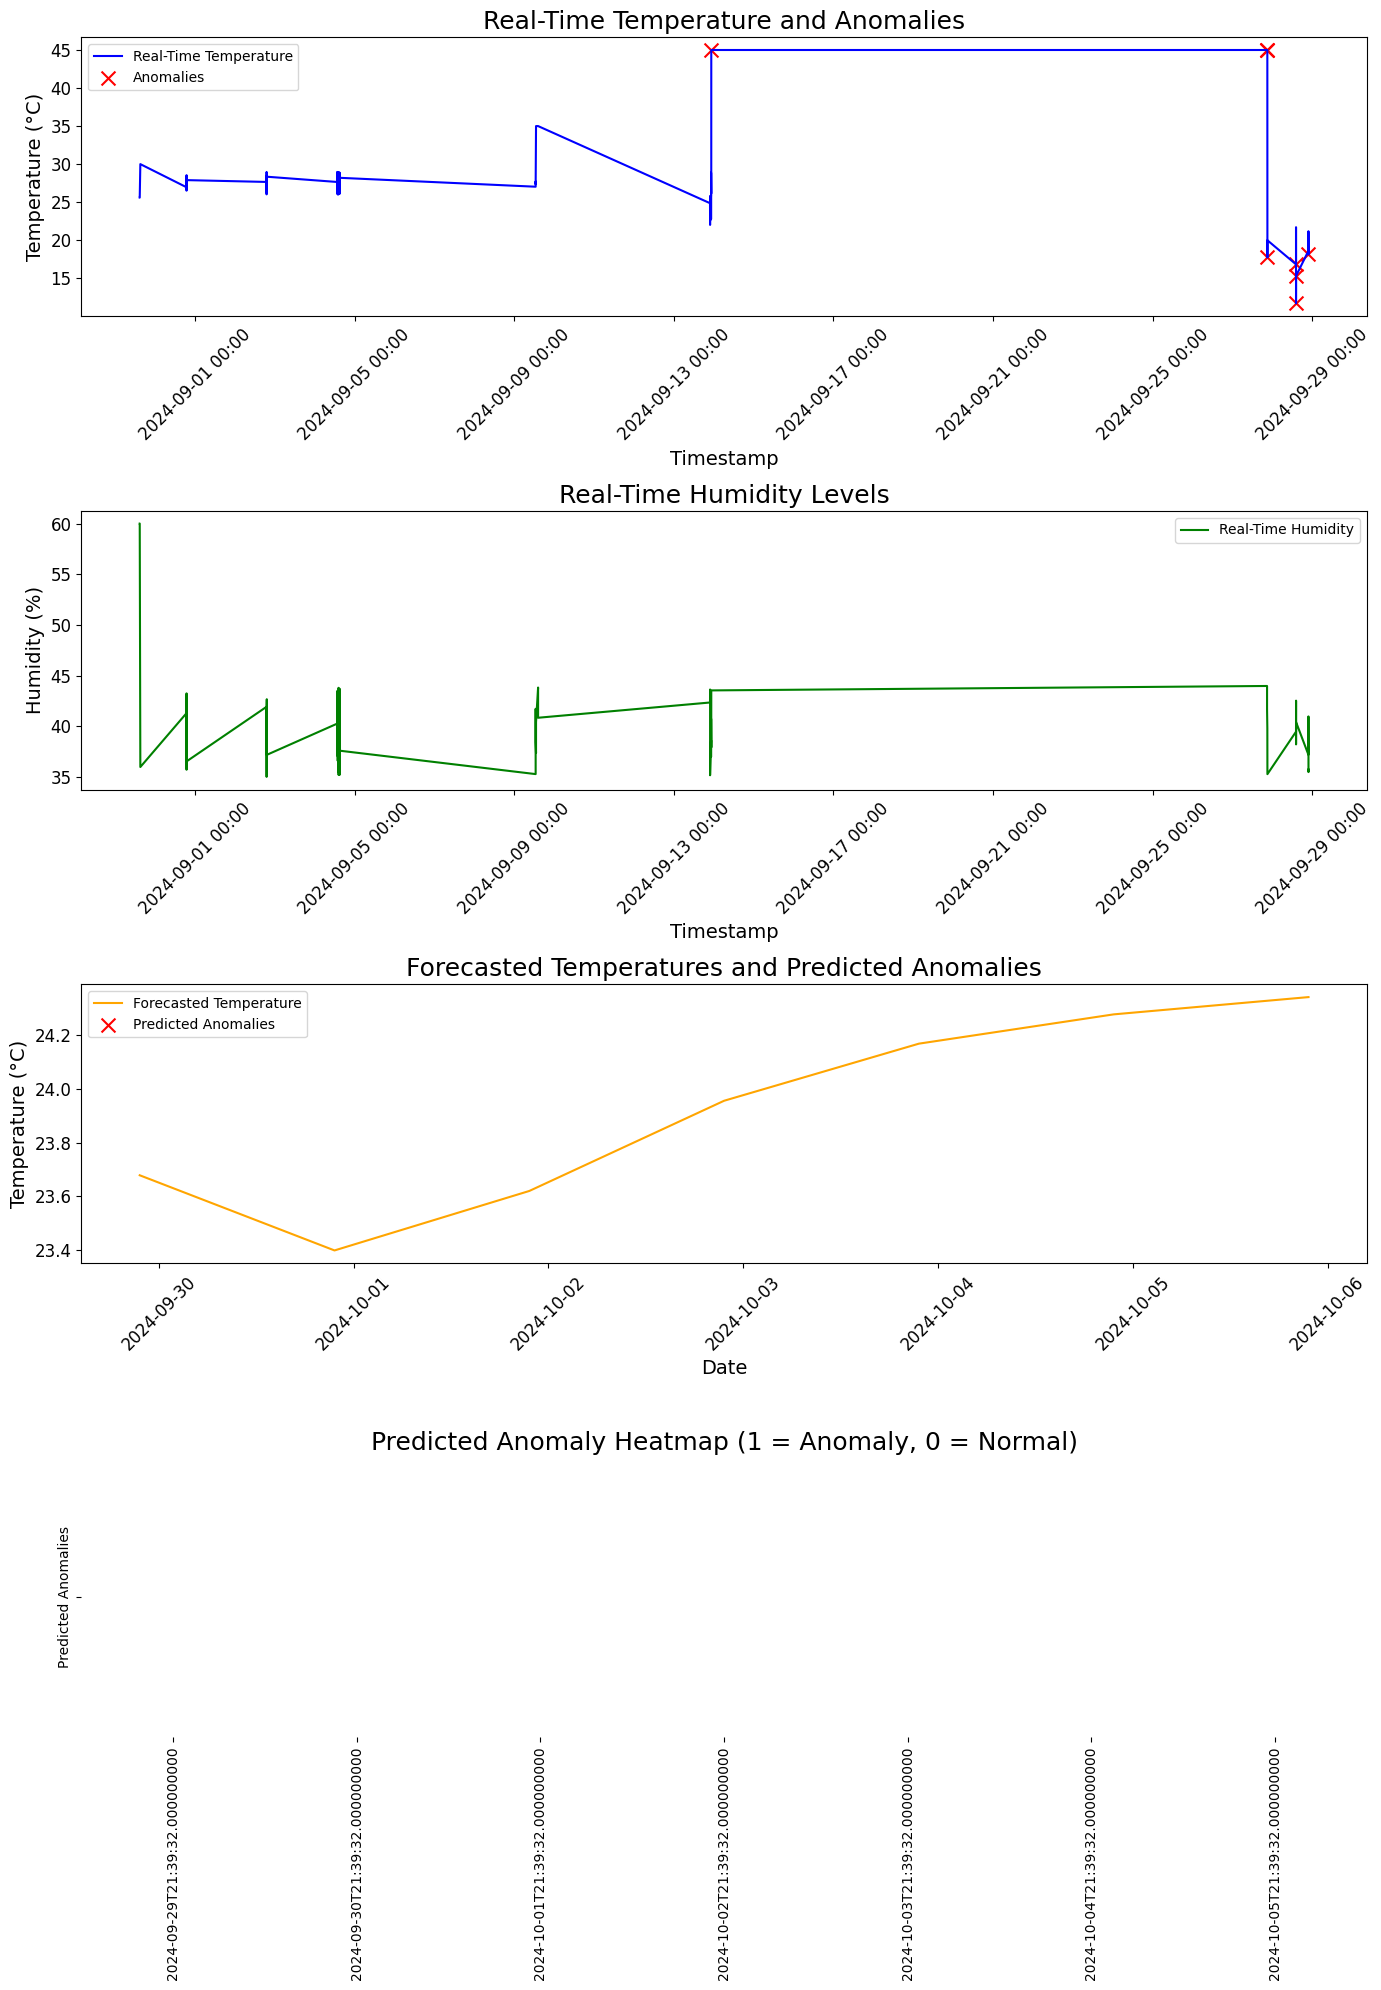

No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).squeeze()  # Squeeze to match dimensions

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for epoch in range(epochs):
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq).squeeze()
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold_factor=2):
    """Detect anomalies based on the temperature deviations from the mean or predicted values."""
    if predicted_values is None:
        mean_temp = np.mean(temperature_values)
        std_temp = np.std(temperature_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    else:
        differences = temperature_values - predicted_values
        std_diff = np.std(differences)
        mean_diff = np.mean(differences)
        upper_threshold = mean_diff + threshold_factor * std_diff
        lower_threshold = mean_diff - threshold_factor * std_diff
        anomalies = (differences > upper_threshold) | (differences < lower_threshold)
    return anomalies
def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        
        # Drop rows where timestamp or temperature/humidity is missing
        df.dropna(subset=['timestamp', 'temperature', 'humidity'], inplace=True)
        
        df.sort_values('timestamp', inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df


def visualize_realtime_data(df, forecast, anomalies, future_anomalies, future_forecast_dates):
    # Increase the size of the plots and make texts more readable
    fig, axs = plt.subplots(4, 1, figsize=(14, 20))

    # Set common parameters for all plots
    title_fontsize = 18
    label_fontsize = 14
    tick_labelsize = 12

    # Plot 1: Real-time temperature and anomalies
    axs[0].plot(df['timestamp'], df['temperature'], label='Real-Time Temperature', color='blue')
    axs[0].scatter(df['timestamp'][anomalies], df['temperature'][anomalies], color='red', marker='x', s=100, label='Anomalies')
    axs[0].set_xlabel('Timestamp', fontsize=label_fontsize)
    axs[0].set_ylabel('Temperature (°C)', fontsize=label_fontsize)
    axs[0].set_title('Real-Time Temperature and Anomalies', fontsize=title_fontsize)
    axs[0].legend()
    axs[0].tick_params(axis='x', labelsize=tick_labelsize)
    axs[0].tick_params(axis='y', labelsize=tick_labelsize)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[0].tick_params(axis='x', rotation=45)

    # Plot 2: Real-time humidity levels
    axs[1].plot(df['timestamp'], df['humidity'], label='Real-Time Humidity', color='green')
    axs[1].set_xlabel('Timestamp', fontsize=label_fontsize)
    axs[1].set_ylabel('Humidity (%)', fontsize=label_fontsize)
    axs[1].set_title('Real-Time Humidity Levels', fontsize=title_fontsize)
    axs[1].legend()
    axs[1].tick_params(axis='x', labelsize=tick_labelsize)
    axs[1].tick_params(axis='y', labelsize=tick_labelsize)
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[1].tick_params(axis='x', rotation=45)

    # Plot 3: Forecasted temperatures and future anomalies
    axs[2].plot(future_forecast_dates, forecast, label='Forecasted Temperature', color='orange')
    axs[2].scatter(future_forecast_dates[future_anomalies], forecast[future_anomalies], color='red', marker='x', s=100, label='Predicted Anomalies')
    axs[2].set_xlabel('Date', fontsize=label_fontsize)
    axs[2].set_ylabel('Temperature (°C)', fontsize=label_fontsize)
    axs[2].set_title('Forecasted Temperatures and Predicted Anomalies', fontsize=title_fontsize)
    axs[2].legend()
    axs[2].tick_params(axis='x', labelsize=tick_labelsize)
    axs[2].tick_params(axis='y', labelsize=tick_labelsize)
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[2].tick_params(axis='x', rotation=45)

    # Plot 4: Anomaly heatmap for future anomalies
    anomaly_heatmap_data = pd.DataFrame({'Predicted Anomalies': future_anomalies.astype(int)}, index=future_forecast_dates)
    sns.heatmap(anomaly_heatmap_data.T, ax=axs[3], cmap="coolwarm", cbar=False)
    axs[3].set_title('Predicted Anomaly Heatmap (1 = Anomaly, 0 = Normal)', fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()

def process_realtime_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values

            # Detect anomalies in real-time data
            anomalies = detect_anomalies(real_time_temperatures)

            # Predict next 7 days temperatures using SARIMA
            sarima_forecast = sarima_model_fit.forecast(steps=7)

            # Prepare input for LSTM forecasting
            last_residuals = residuals.values[-seq_length:]  # Get last seq_length residuals
            last_residuals_scaled = scaler.transform(last_residuals.reshape(-1, 1))
            last_residuals_sequence = torch.tensor(last_residuals_scaled.reshape(1, seq_length, 1), dtype=torch.float32)

            # Forecast future residuals with LSTM
            model.eval()
            with torch.no_grad():
                lstm_forecast_scaled = model(last_residuals_sequence).numpy().flatten()

            # Inverse transform the forecasted residuals
            lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled.reshape(-1, 1)).flatten()

            # Combine SARIMA and LSTM forecasts
            forecast = sarima_forecast + lstm_forecast

            # Create future dates for the forecast
            future_forecast_dates = pd.date_range(start=real_time_data['timestamp'].iloc[-1] + pd.Timedelta(days=1), periods=7, freq='D')

            # Detect anomalies in the forecasted temperatures
            future_anomalies = detect_anomalies(forecast)

            # Visualize data including future anomalies
            visualize_realtime_data(real_time_data, forecast, anomalies, future_anomalies, future_forecast_dates)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_data()


Epoch 1/100, Loss: 0.007514867465943098
Epoch 2/100, Loss: 0.0036017303355038166
Epoch 3/100, Loss: 0.011019179597496986
Epoch 4/100, Loss: 0.02242056466639042
Epoch 5/100, Loss: 0.00796474888920784
Epoch 6/100, Loss: 0.006432527210563421
Epoch 7/100, Loss: 0.0170084647834301
Epoch 8/100, Loss: 0.017842575907707214
Epoch 9/100, Loss: 0.007481375243514776
Epoch 10/100, Loss: 0.015654953196644783
Epoch 11/100, Loss: 0.009318463504314423
Epoch 12/100, Loss: 0.007954724133014679
Epoch 13/100, Loss: 0.006397688761353493
Epoch 14/100, Loss: 0.00733700767159462
Epoch 15/100, Loss: 0.007084283512085676
Epoch 16/100, Loss: 0.007803954649716616
Epoch 17/100, Loss: 0.010988933965563774
Epoch 18/100, Loss: 0.009160000830888748
Epoch 19/100, Loss: 0.0069619943387806416
Epoch 20/100, Loss: 0.011405580677092075
Epoch 21/100, Loss: 0.006526264362037182
Epoch 22/100, Loss: 0.012261542491614819
Epoch 23/100, Loss: 0.0025075229350477457
Epoch 24/100, Loss: 0.006463479716330767
Epoch 25/100, Loss: 0.00656

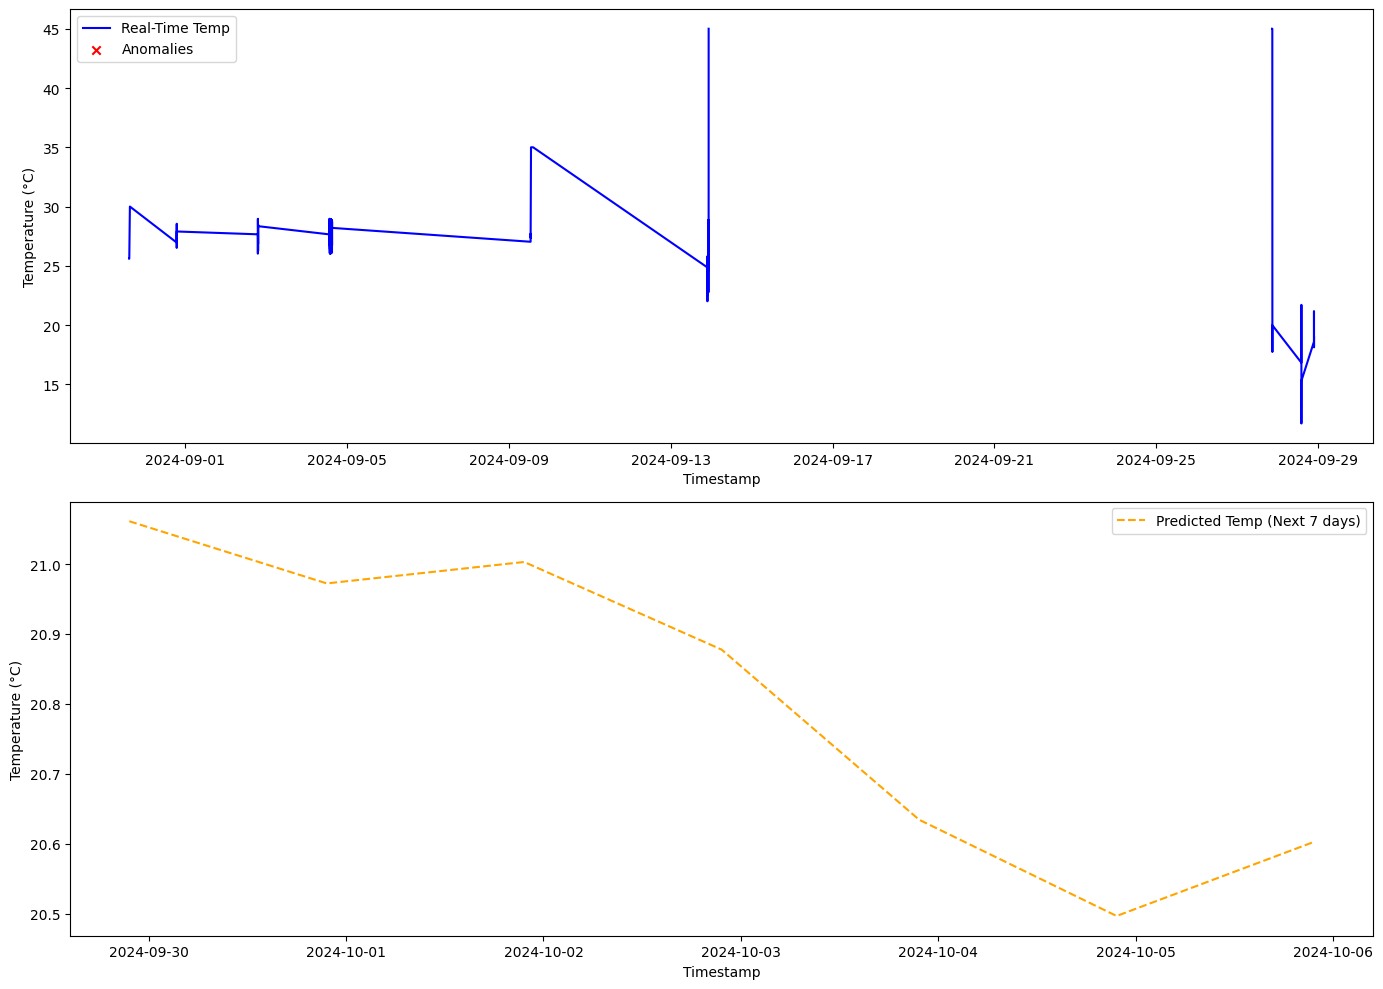

No new real-time data.


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Loc

Epoch 1/100, Loss: 0.0017640540609136224
Epoch 2/100, Loss: 0.001684141461737454
Epoch 3/100, Loss: 0.002407435793429613
Epoch 4/100, Loss: 0.004791564773768187
Epoch 5/100, Loss: 0.002057417528703809
Epoch 6/100, Loss: 0.003461559070274234
Epoch 7/100, Loss: 0.0015530299860984087
Epoch 8/100, Loss: 0.002687153173610568
Epoch 9/100, Loss: 0.0024779867380857468
Epoch 10/100, Loss: 0.0009530996903777122
Epoch 11/100, Loss: 0.0029144897125661373
Epoch 12/100, Loss: 0.0032827092800289392
Epoch 13/100, Loss: 0.0011393068125471473
Epoch 14/100, Loss: 0.0016576881753280759
Epoch 15/100, Loss: 0.0017210838850587606
Epoch 16/100, Loss: 0.00146467424929142
Epoch 17/100, Loss: 0.004050922114402056
Epoch 18/100, Loss: 0.0011942768469452858
Epoch 19/100, Loss: 0.002067402470856905
Epoch 20/100, Loss: 0.001905202167108655
Epoch 21/100, Loss: 0.0031096499878913164
Epoch 22/100, Loss: 0.004511888138949871
Epoch 23/100, Loss: 0.0025114736054092646
Epoch 24/100, Loss: 0.0019805009942501783
Epoch 25/100,

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


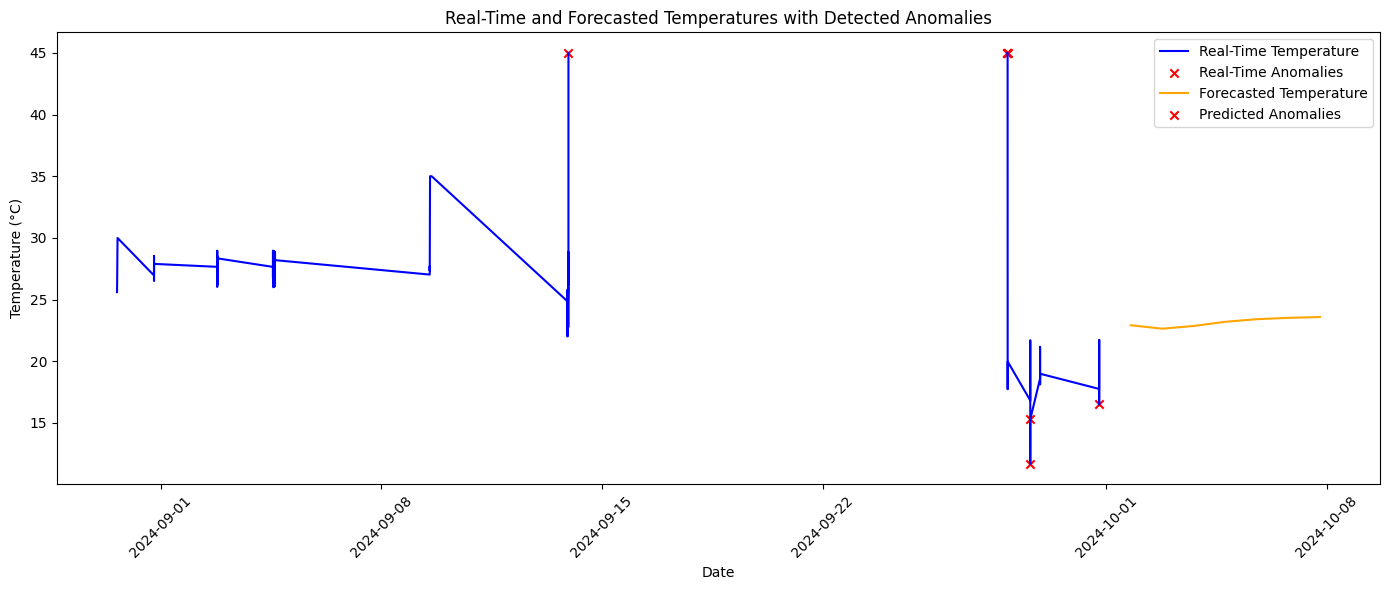

No real-time data found in DynamoDB.
No new real-time data available.
No real-time data found in DynamoDB.
No new real-time data available.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold_factor=2):
    """Detect anomalies based on the temperature deviations from the mean or predicted values."""
    if predicted_values is None:
        mean_temp = np.mean(temperature_values)
        std_temp = np.std(temperature_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    else:
        mean_temp = np.mean(predicted_values)
        std_temp = np.std(predicted_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

def visualize_realtime_and_forecast_data(df, forecast, real_time_anomalies, future_anomalies, future_forecast_dates):
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot real-time temperature and detected anomalies
    ax.plot(df['timestamp'], df['temperature'], label='Real-Time Temperature', color='blue')
    ax.scatter(df['timestamp'][real_time_anomalies], df['temperature'][real_time_anomalies], color='red', marker='x', label='Real-Time Anomalies')

    # Plot forecasted temperature
    ax.plot(future_forecast_dates, forecast, label='Forecasted Temperature', color='orange')

    # Plot predicted anomalies in forecasted data
    ax.scatter(future_forecast_dates[future_anomalies], forecast[future_anomalies], color='red', marker='x', label='Predicted Anomalies')

    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Real-Time and Forecasted Temperatures with Detected Anomalies')
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def process_realtime_and_forecast_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values

            # Detect anomalies in real-time data
            real_time_anomalies = detect_anomalies(real_time_temperatures)

            # Predict next 7 days temperatures using SARIMA
            sarima_forecast = sarima_model_fit.forecast(steps=7)

            # Prepare input for LSTM forecasting
            last_residuals = residuals.values[-seq_length:]  # Get last seq_length residuals
            last_residuals_scaled = scaler.transform(last_residuals.reshape(-1, 1))
            last_residuals_sequence = torch.tensor(last_residuals_scaled.reshape(1, seq_length, 1), dtype=torch.float32)

            # Forecast future residuals with LSTM
            model.eval()
            with torch.no_grad():
                lstm_forecast_scaled = model(last_residuals_sequence).numpy().flatten()

            # Inverse transform the forecasted residuals
            lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled.reshape(-1, 1)).flatten()

            # Combine SARIMA and LSTM forecasts
            forecast = sarima_forecast + lstm_forecast

            # Create future dates for the forecast
            future_forecast_dates = pd.date_range(start=real_time_data['timestamp'].iloc[-1] + pd.Timedelta(days=1), periods=7, freq='D')

            # Detect anomalies in the forecasted temperatures
            future_anomalies = detect_anomalies(forecast)

            # Visualize data including future anomalies
            visualize_realtime_and_forecast_data(real_time_data, forecast, real_time_anomalies, future_anomalies, future_forecast_dates)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_and_forecast_data()


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Loc

Epoch 1/100, Loss: 0.0024806857109069824
Epoch 2/100, Loss: 0.0024996104184538126
Epoch 3/100, Loss: 0.00403811689466238
Epoch 4/100, Loss: 0.0038136604707688093
Epoch 5/100, Loss: 0.0022553224116563797
Epoch 6/100, Loss: 0.002462365897372365
Epoch 7/100, Loss: 0.0027598405722528696
Epoch 8/100, Loss: 0.006986371707171202
Epoch 9/100, Loss: 0.004060299601405859
Epoch 10/100, Loss: 0.0036726875696331263
Epoch 11/100, Loss: 0.0010411088587716222
Epoch 12/100, Loss: 0.002742328215390444
Epoch 13/100, Loss: 0.004577684216201305
Epoch 14/100, Loss: 0.002759686205536127
Epoch 15/100, Loss: 0.0036080905701965094
Epoch 16/100, Loss: 0.004285148344933987
Epoch 17/100, Loss: 0.0034295490477234125
Epoch 18/100, Loss: 0.007540041580796242
Epoch 19/100, Loss: 0.002138518961146474
Epoch 20/100, Loss: 0.0020699261222034693
Epoch 21/100, Loss: 0.0021484403405338526
Epoch 22/100, Loss: 0.0036441832780838013
Epoch 23/100, Loss: 0.003301429795101285
Epoch 24/100, Loss: 0.00279645761474967
Epoch 25/100, L

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


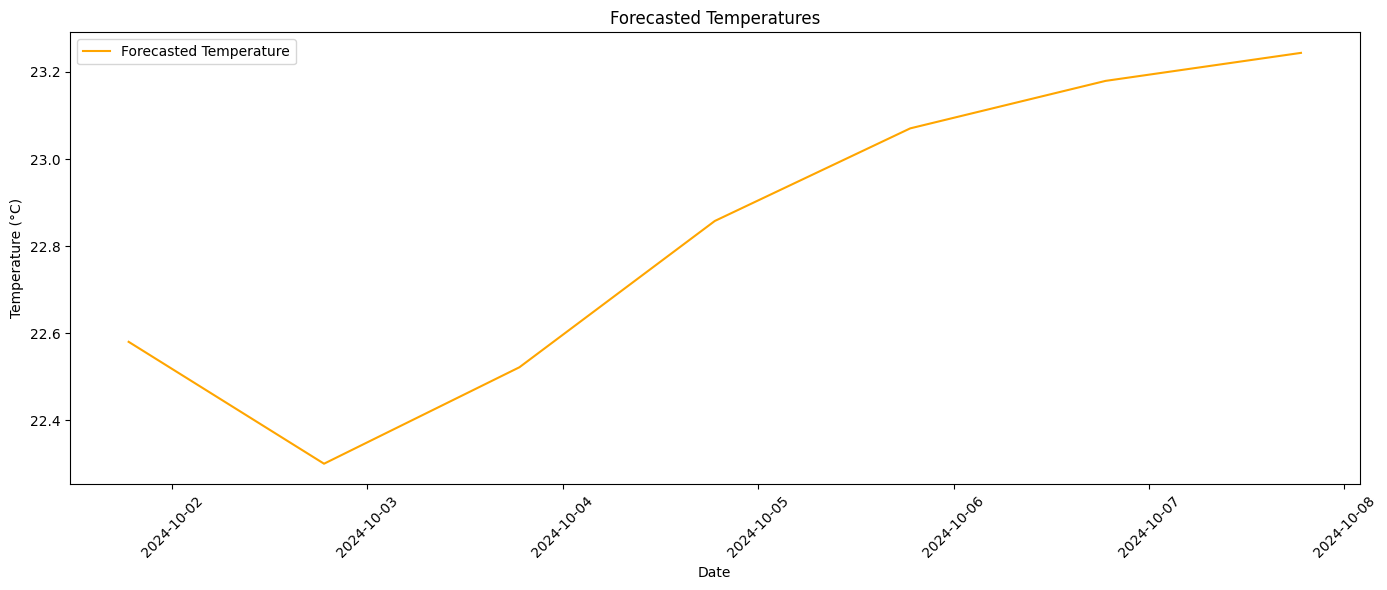

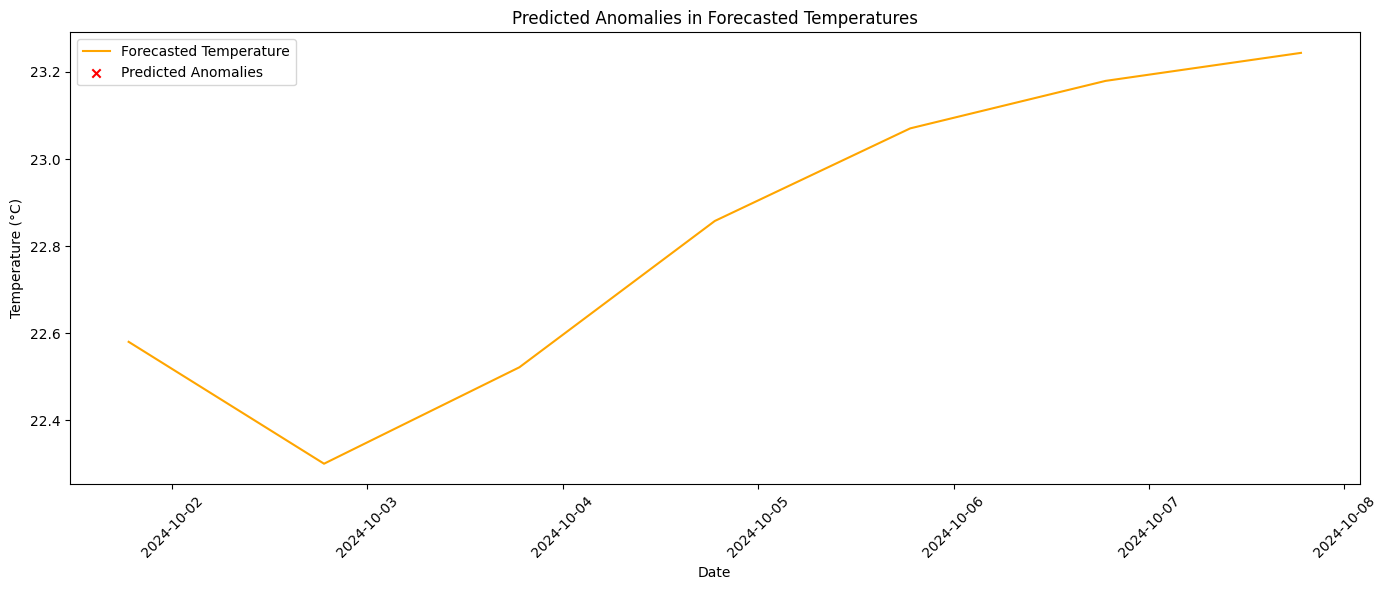

No real-time data found in DynamoDB.
No new real-time data available.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold_factor=2):
    """Detect anomalies based on the temperature deviations from the mean or predicted values."""
    if predicted_values is None:
        mean_temp = np.mean(temperature_values)
        std_temp = np.std(temperature_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    else:
        mean_temp = np.mean(predicted_values)
        std_temp = np.std(predicted_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

def visualize_forecasting_and_anomalies(forecast, future_forecast_dates, future_anomalies, real_time_data):
    # Plot forecasted temperatures
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(future_forecast_dates, forecast, label='Forecasted Temperature', color='orange')

    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Forecasted Temperatures')
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot forecasted anomalies
    fig, ax2 = plt.subplots(figsize=(14, 6))
    ax2.plot(future_forecast_dates, forecast, label='Forecasted Temperature', color='orange')
    ax2.scatter(future_forecast_dates[future_anomalies], forecast[future_anomalies], color='red', marker='x', label='Predicted Anomalies')

    ax2.set_xlabel('Date')
    ax2.set_ylabel('Temperature (°C)')
    ax2.set_title('Predicted Anomalies in Forecasted Temperatures')
    ax2.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def process_realtime_and_forecast_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values

            # Detect anomalies in real-time data
            real_time_anomalies = detect_anomalies(real_time_temperatures)

            # Predict next 7 days temperatures using SARIMA
            sarima_forecast = sarima_model_fit.forecast(steps=7)

            # Prepare input for LSTM forecasting
            last_residuals = residuals.values[-seq_length:]  # Get last seq_length residuals
            last_residuals_scaled = scaler.transform(last_residuals.reshape(-1, 1))
            last_residuals_sequence = torch.tensor(last_residuals_scaled.reshape(1, seq_length, 1), dtype=torch.float32)

            # Forecast future residuals with LSTM
            model.eval()
            with torch.no_grad():
                lstm_forecast_scaled = model(last_residuals_sequence).numpy().flatten()

            # Inverse transform the forecasted residuals
            lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled.reshape(-1, 1)).flatten()

            # Combine SARIMA and LSTM forecasts
            forecast = sarima_forecast + lstm_forecast

            # Create future dates for the forecast
            future_forecast_dates = pd.date_range(start=real_time_data['timestamp'].iloc[-1] + pd.Timedelta(days=1), periods=7, freq='D')

            # Detect anomalies in the forecasted temperatures
            future_anomalies = detect_anomalies(forecast)

            # Visualize data including future anomalies
            visualize_forecasting_and_anomalies(forecast, future_forecast_dates, future_anomalies, real_time_data)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Start real-time processing
process_realtime_and_forecast_data()


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely

Epoch 1/100, Loss: 1.6860577755142003


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\

Epoch 2/100, Loss: 0.10952703841030598


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3/100, Loss: 0.10531445383094251


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4/100, Loss: 0.10753975878469646


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/100, Loss: 0.10633229906670749


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 6/100, Loss: 0.10484436340630054


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 7/100, Loss: 0.10701681405771524


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 8/100, Loss: 0.10431573924142867


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9/100, Loss: 0.10647218767553568


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/100, Loss: 0.10597477247938514


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 11/100, Loss: 0.10436455172020942


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 12/100, Loss: 0.10692243848461658


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 13/100, Loss: 0.10572296043392271


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 14/100, Loss: 0.10848335910122842


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 15/100, Loss: 0.1122649444732815


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 16/100, Loss: 0.10921451239846647


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 17/100, Loss: 0.10607807955238968


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 18/100, Loss: 0.10661157115828246


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 19/100, Loss: 0.10692866751924157


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/100, Loss: 0.10535758337937295


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 21/100, Loss: 0.10780434985645115


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 22/100, Loss: 0.11060308013111353


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 23/100, Loss: 0.10542049631476402


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 24/100, Loss: 0.10539486142806709


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 25/100, Loss: 0.10542091587558389


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 26/100, Loss: 0.1066738348454237


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 27/100, Loss: 0.10503877280279994


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 28/100, Loss: 0.1054047045763582


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 29/100, Loss: 0.1095068131107837


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 30/100, Loss: 0.11213829228654504


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 31/100, Loss: 0.10573116829618812


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 32/100, Loss: 0.10681882302742451


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 33/100, Loss: 0.11020295403432101


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 34/100, Loss: 0.10809783637523651


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 35/100, Loss: 0.105728097143583


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 36/100, Loss: 0.10552418360020965


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 37/100, Loss: 0.10616085526999086


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 38/100, Loss: 0.11281014885753393


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 39/100, Loss: 0.10527781338896602


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/100, Loss: 0.10572126263286918


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 41/100, Loss: 0.10631690104492009


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 42/100, Loss: 0.10512949631083757


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 43/100, Loss: 0.10723484470508993


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 44/100, Loss: 0.10888097563292831


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 45/100, Loss: 0.10907480318564922


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 46/100, Loss: 0.11056297190953046


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 47/100, Loss: 0.11149373394437134


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 48/100, Loss: 0.11467575340066105


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49/100, Loss: 0.10818022105377167


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50/100, Loss: 0.10539163334760815


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 51/100, Loss: 0.10486862773541361


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 52/100, Loss: 0.10648455505724996


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 53/100, Loss: 0.10523015959188342


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 54/100, Loss: 0.10680054628755897


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 55/100, Loss: 0.10813048633281142


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 56/100, Loss: 0.10952739068306983


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 57/100, Loss: 0.10656841145828366


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 58/100, Loss: 0.10522172879427671


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 59/100, Loss: 0.10710840090177953


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/100, Loss: 0.10645085899159312


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 61/100, Loss: 0.10763113258872181


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 62/100, Loss: 0.1086766729131341


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 63/100, Loss: 0.10693417163565755


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 64/100, Loss: 0.10570781514979899


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 65/100, Loss: 0.10854626935906708


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 66/100, Loss: 0.11010481091216207


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 67/100, Loss: 0.10632430098485202


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 68/100, Loss: 0.10556749533861876


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 69/100, Loss: 0.10559573117643595


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 70/100, Loss: 0.10637746995780617


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 71/100, Loss: 0.10660504212137312


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 72/100, Loss: 0.10493263078387827


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 73/100, Loss: 0.10516556981019676


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 74/100, Loss: 0.10739739274140447


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 75/100, Loss: 0.10638163075782359


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 76/100, Loss: 0.1061162855476141


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 77/100, Loss: 0.10793867136817425


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 78/100, Loss: 0.10538731550332159


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 79/100, Loss: 0.10910953173879534


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/100, Loss: 0.10633914615027606


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 81/100, Loss: 0.10792772599961609


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 82/100, Loss: 0.10792946082074195


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 83/100, Loss: 0.1070745293982327


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 84/100, Loss: 0.10768032830674201


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 85/100, Loss: 0.10585872258525342


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 86/100, Loss: 0.10555386659689248


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 87/100, Loss: 0.10685728839598596


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 88/100, Loss: 0.10879192291758955


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 89/100, Loss: 0.10521543608047068


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 90/100, Loss: 0.10631222859956324


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 91/100, Loss: 0.10462474706582725


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 92/100, Loss: 0.10937933973036706


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 93/100, Loss: 0.10826757794711739


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 94/100, Loss: 0.10724803921766579


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 95/100, Loss: 0.1052569072926417


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 96/100, Loss: 0.1085900526959449


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 97/100, Loss: 0.1060143766226247


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 98/100, Loss: 0.10668527113739401


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 99/100, Loss: 0.10818071197718382


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([15, 1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100/100, Loss: 0.10757036705035716


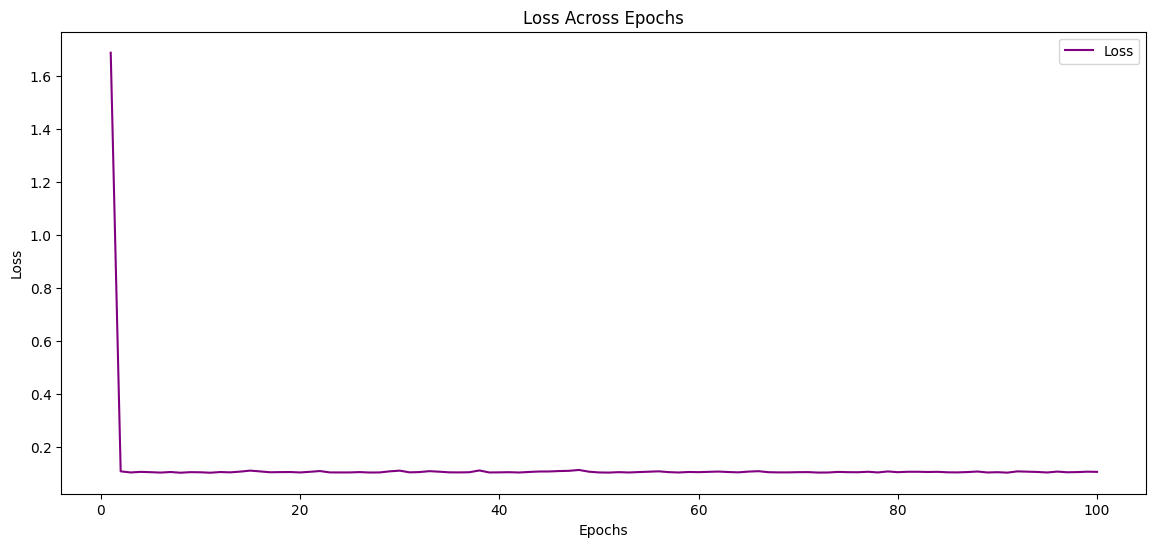

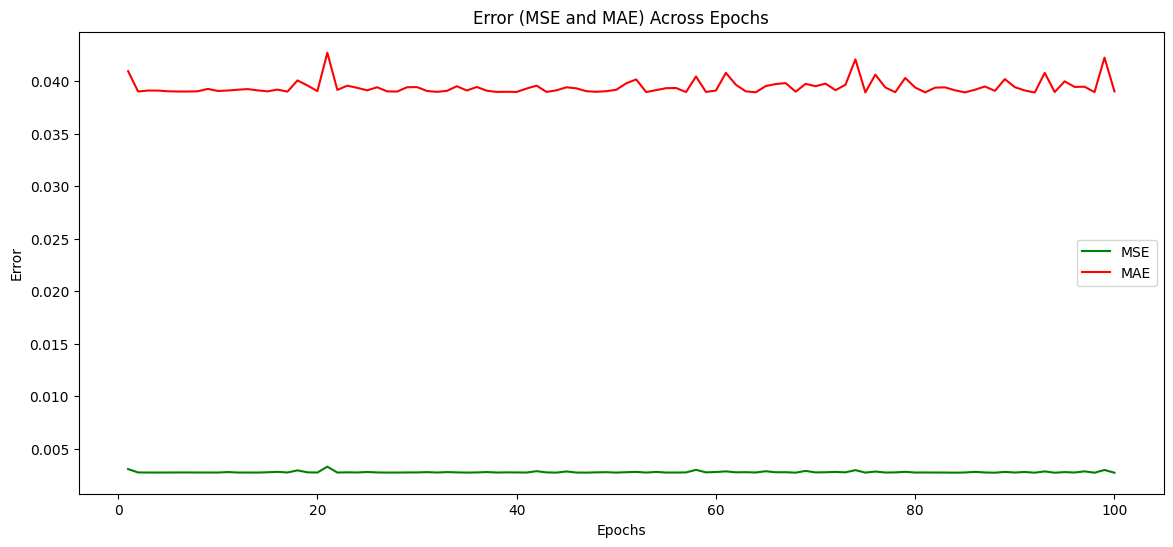

Real-time data fetched and preprocessed:
   humidity sensor_id  temperature           timestamp
0      60.0   sensor1         25.6 2024-08-30 14:46:26
1      60.0   sensor1         25.6 2024-08-30 14:46:37
2      60.0   sensor1         25.6 2024-08-30 14:46:47
3      60.0   sensor1         25.6 2024-08-30 14:46:57
4      36.0   sensor1         30.0 2024-08-30 15:08:34


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track loss and error parameters for each epoch
epoch_losses = []
mse_errors = []
mae_errors = []

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    epoch_loss = 0
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_losses.append(epoch_loss)
    
    # Compute errors for each epoch
    y_pred_flat = model(X).detach().numpy().flatten()
    y_flat = y.detach().numpy().flatten()
    mse_errors.append(mean_squared_error(y_flat, y_pred_flat))
    mae_errors.append(mean_absolute_error(y_flat, y_pred_flat))
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

# Step 8: Define the function to fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def detect_anomalies(temperature_values, predicted_values=None, threshold_factor=2):
    """Detect anomalies based on the temperature deviations from the mean or predicted values."""
    if predicted_values is None:
        mean_temp = np.mean(temperature_values)
        std_temp = np.std(temperature_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    else:
        mean_temp = np.mean(predicted_values)
        std_temp = np.std(predicted_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    return anomalies

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

def visualize_forecasting_and_anomalies(forecast, future_forecast_dates, future_anomalies, real_time_data, real_time_anomalies):
    # Plot forecasted temperatures
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(future_forecast_dates, forecast, label='Forecasted Temperature', color='orange')

    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Forecasted Temperatures')
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot forecasted anomalies
    fig, ax2 = plt.subplots(figsize=(14, 6))
    ax2.plot(future_forecast_dates, forecast, label='Forecasted Temperature', color='orange')
    ax2.scatter(future_forecast_dates[future_anomalies], forecast[future_anomalies], color='red', marker='x', label='Predicted Anomalies')

    ax2.set_xlabel('Date')
    ax2.set_ylabel('Temperature (°C)')
    ax2.set_title('Predicted Anomalies in Forecasted Temperatures')
    ax2.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot real-time temperatures and detected anomalies
    fig, ax3 = plt.subplots(figsize=(14, 6))
    ax3.plot(real_time_data['timestamp'], real_time_data['temperature'], label='Real-Time Temperature', color='blue')
    ax3.scatter(real_time_data['timestamp'][real_time_anomalies], real_time_data['temperature'][real_time_anomalies], color='red', marker='x', s=100, label='Real-Time Anomalies')

    ax3.set_xlabel('Timestamp')
    ax3.set_ylabel('Temperature (°C)')
    ax3.set_title('Real-Time Temperature and Anomalies')
    ax3.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_epoch_loss_and_errors(epoch_losses, mse_errors, mae_errors):
    # Plot epoch loss
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Loss', color='purple')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Across Epochs')
    plt.legend()
    plt.show()

    # Plot MSE and MAE across epochs
    fig, ax2 = plt.subplots(figsize=(14, 6))
    ax2.plot(range(1, len(mse_errors) + 1), mse_errors, label='MSE', color='green')
    ax2.plot(range(1, len(mae_errors) + 1), mae_errors, label='MAE', color='red')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Error')
    ax2.set_title('Error (MSE and MAE) Across Epochs')
    plt.legend()
    plt.show()

def process_realtime_and_forecast_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values

            # Predict next 7 days temperatures using SARIMA + LSTM hybrid model
            sarima_forecast = sarima_model_fit.forecast(steps=7)
            lstm_forecast = model(X[-1:].unsqueeze(0)).detach().numpy().flatten()
            forecast = sarima_forecast + lstm_forecast

            # Create future dates for the forecast
            future_forecast_dates = pd.date_range(start=real_time_data['timestamp'].iloc[-1] + pd.Timedelta(days=1), periods=7, freq='D')

            # Detect anomalies in the forecasted temperatures
            future_anomalies = detect_anomalies(forecast)

            # Detect anomalies in real-time data
            real_time_anomalies = detect_anomalies(real_time_temperatures)

            # Visualize data including future anomalies and real-time anomalies
            visualize_forecasting_and_anomalies(forecast, future_forecast_dates, future_anomalies, real_time_data, real_time_anomalies)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching

# Step 9: Plot loss and error metrics
plot_epoch_loss_and_errors(epoch_losses, mse_errors, mae_errors)

# Start real-time processing
process_realtime_and_forecast_data()


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time

# Fix OpenMP conflict
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)

# Set the frequency explicitly
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Step 2: Train SARIMA Model (Monthly and Yearly)
sarima_order = (1, 1, 1)
seasonal_order_monthly = (1, 1, 1, 12)  # Monthly seasonality
seasonal_order_yearly = (1, 1, 1, 30)  # Yearly seasonality

sarima_model_monthly = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order_monthly)
sarima_model_yearly = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order_yearly)

# Limit the number of threads used by OpenMP (threadpoolctl workaround)
from threadpoolctl import threadpool_limits

with threadpool_limits(limits=1):
    sarima_model_fit_monthly = sarima_model_monthly.fit(disp=False)
    sarima_model_fit_yearly = sarima_model_yearly.fit(disp=False)



sarima_model_fit_monthly = sarima_model_monthly.fit(disp=False)
sarima_model_fit_yearly = sarima_model_yearly.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions_monthly = sarima_model_fit_monthly.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
sarima_predictions_yearly = sarima_model_fit_yearly.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals_monthly = df_mongo['tavg'] - sarima_predictions_monthly
residuals_yearly = df_mongo['tavg'] - sarima_predictions_yearly
residuals_monthly.dropna(inplace=True)
residuals_yearly.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals_monthly = scaler.fit_transform(residuals_monthly.values.reshape(-1, 1))
scaled_residuals_yearly = scaler.fit_transform(residuals_yearly.values.reshape(-1, 1))
# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Step 5: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only last output is needed
        return predictions

# Step 6: Train the LSTM Model
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track loss and error parameters for each epoch
epoch_losses = []
mse_errors = []
mae_errors = []

# Step 7: Create a custom Dataset for LSTM
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = WeatherDataset(X, y)

# Train LSTM with the correct dataset in DataLoader
epochs = 100
for epoch in range(epochs):
    epoch_loss = 0
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_losses.append(epoch_loss)
    
    # Compute errors for each epoch
    y_pred_flat = model(X).detach().numpy().flatten()
    y_flat = y.detach().numpy().flatten()
    mse_errors.append(mean_squared_error(y_flat, y_pred_flat))
    mae_errors.append(mean_absolute_error(y_flat, y_pred_flat))
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')

# Step 6: Define real-time data anomaly detection
def detect_anomalies(temperature_values, predicted_values=None, threshold_factor=2):
    if predicted_values is None:
        mean_temp = np.mean(temperature_values)
        std_temp = np.std(temperature_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    else:
        mean_temp = np.mean(predicted_values)
        std_temp = np.std(predicted_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    return anomalies

# Step 7: Fetch real-time data from DynamoDB
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def fetch_realtime_data(last_timestamp=None):
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()
        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
    return df

# Step 8: Visualize monthly/yearly forecast and anomalies
def visualize_forecasting_and_anomalies(forecast, future_forecast_dates, future_anomalies, real_time_data):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(future_forecast_dates, forecast, label='Forecasted Temperature', color='orange')
    ax.scatter(future_forecast_dates[future_anomalies], forecast[future_anomalies], color='red', marker='x', label='Predicted Anomalies')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Forecasted Temperatures with Anomalies')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Step 9: Monthly and Yearly Forecasting
def process_realtime_and_forecast_data():
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()
            real_time_temperatures = real_time_data['temperature'].values

            # Monthly Forecasting with SARIMA
            sarima_forecast_monthly = sarima_model_fit_monthly.forecast(steps=12)
            sarima_forecast_yearly = sarima_model_fit_yearly.forecast(steps=365)

            # Detect anomalies in the monthly and yearly forecast
            future_anomalies_monthly = detect_anomalies(sarima_forecast_monthly)
            future_anomalies_yearly = detect_anomalies(sarima_forecast_yearly)

            # Visualize monthly anomalies
            future_forecast_dates_monthly = pd.date_range(start=real_time_data['timestamp'].iloc[-1] + pd.Timedelta(days=1), periods=12, freq='M')
            future_forecast_dates_yearly = pd.date_range(start=real_time_data['timestamp'].iloc[-1] + pd.Timedelta(days=1), periods=365, freq='D')

            visualize_forecasting_and_anomalies(sarima_forecast_monthly, future_forecast_dates_monthly, future_anomalies_monthly, real_time_data)
            visualize_forecasting_and_anomalies(sarima_forecast_yearly, future_forecast_dates_yearly, future_anomalies_yearly, real_time_data)

        time.sleep(60)

# Start the real-time and forecasting process
process_realtime_and_forecast_data()


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Loc

NameError: name 'scaled_residuals' is not defined

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Epoch 1/40, Loss: 0.0028728845063596964
Epoch 2/40, Loss: 0.0022573615424335003
Epoch 3/40, Loss: 0.0018550714012235403
Epoch 4/40, Loss: 0.002264181850478053
Epoch 5/40, Loss: 0.001920212060213089
Epoch 6/40, Loss: 0.004268269054591656
Epoch 7/40, Loss: 0.0019338506972417235
Epoch 8/40, Loss: 0.0024735855404287577
Epoch 9/40, Loss: 0.0015891916118562222
Epoch 10/40, Loss: 0.004849287215620279
Epoch 11/40, Loss: 0.0036307317204773426
Epoch 12/40, Loss: 0.002784871496260166
Epoch 13/40, Loss: 0.000775935361161828
Epoch 14/40, Loss: 0.0018605749355629086
Epoch 15/40, Loss: 0.0016740222927182913
Epoch 16/40, Loss: 0.002187620149925351
Epoch 17/40, Loss: 0.0022228918969631195
Epoch 18/40, Loss: 0.00472306227311492
Epoch 19/40, Loss: 0.0011845488334074616
Epoch 20/40, Loss: 0.0017546396702528
Epoch 21/40, Loss: 0.002072711940854788
Epoch 22/40, Loss: 0.0035009400453418493
Epoch 23/40, Loss: 0.001978654880076647
Epoch 24/40, Loss: 0.004264284390956163
Epoch 25/40, Loss: 0.0014202301390469074

C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


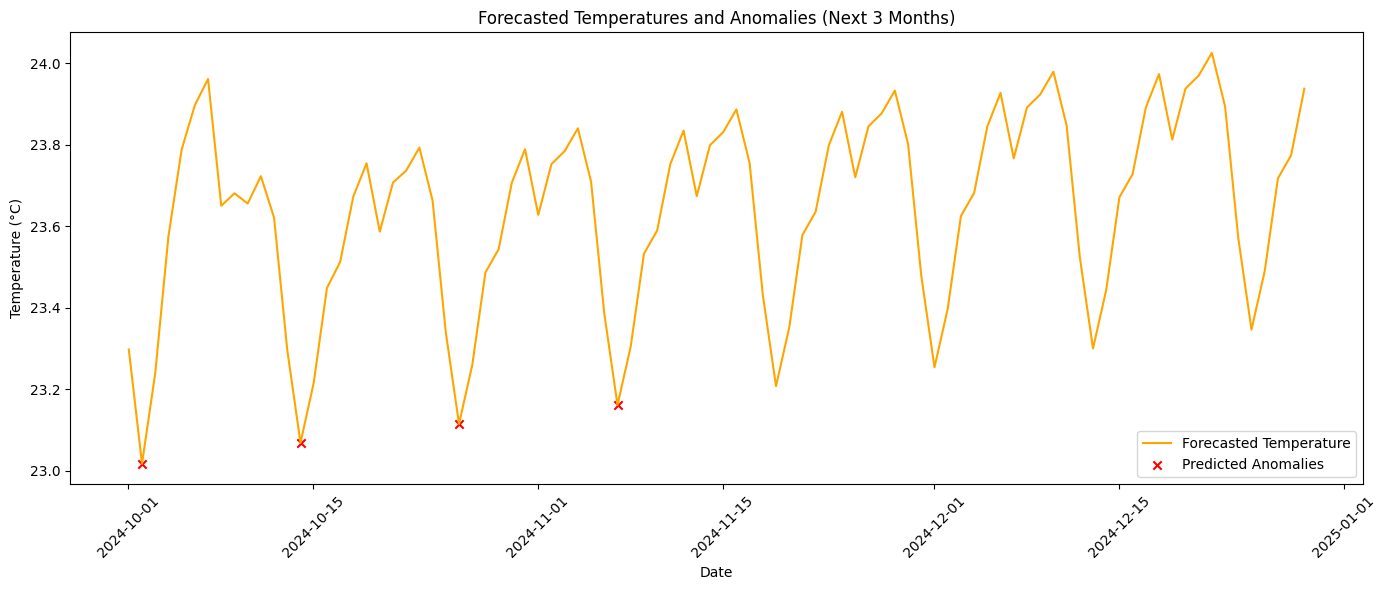

Real-time data fetched and preprocessed:
   humidity sensor_id  temperature                  timestamp
0        85   sensor1           45 2024-09-30 22:33:00.285026


C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\doguk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


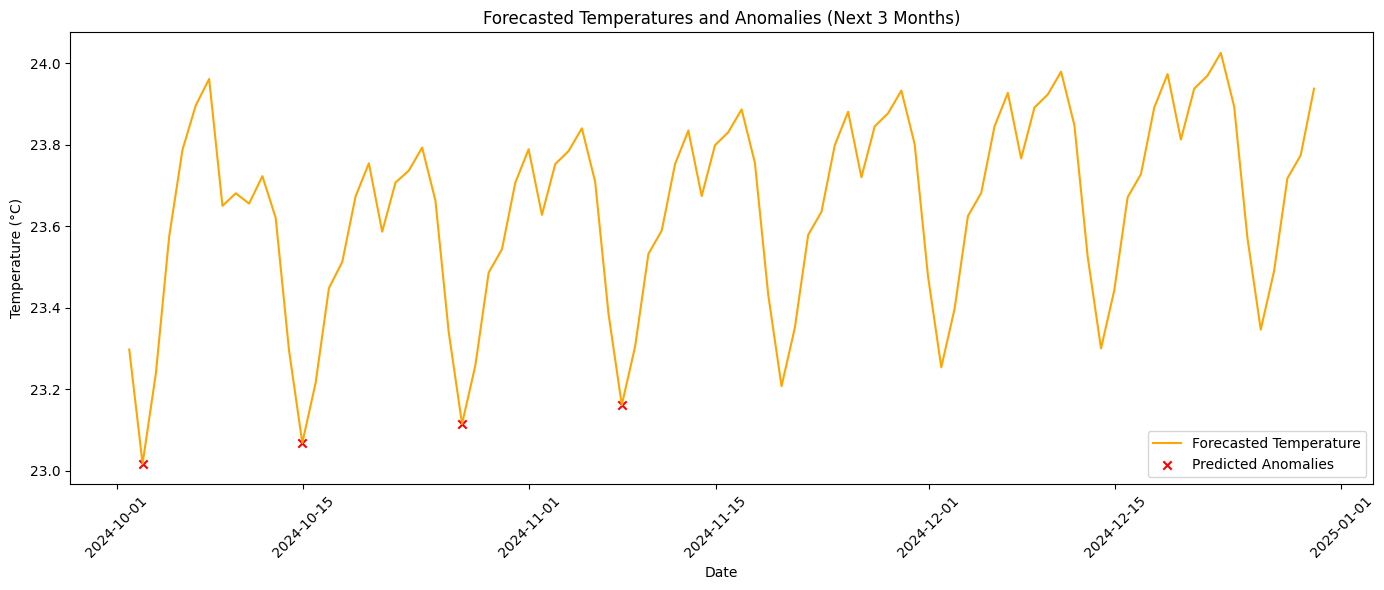

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pymongo import MongoClient
from statsmodels.tsa.statespace.sarimax import SARIMAX
import boto3
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Fix OpenMP conflict
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Step 1: Fetch historical weather data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['weather_data']
collection = db['ankara']

# Fetch data from MongoDB
mongo_data = list(collection.find())
df_mongo = pd.DataFrame(mongo_data)

# Ensure datetime conversion and set index with proper frequency
df_mongo['time'] = pd.to_datetime(df_mongo['time'])
df_mongo.drop_duplicates(subset='time', inplace=True)
df_mongo.set_index('time', inplace=True)

# Set the frequency explicitly (daily data)
df_mongo = df_mongo.asfreq('D')
df_mongo.index.freq = 'D'

# Drop rows with missing values
df_mongo.dropna(subset=['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres'], inplace=True)

# Train SARIMA Model 
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  
sarima_model = SARIMAX(df_mongo['tavg'], order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

# Step 3: Calculate residuals (actual - SARIMA predictions)
sarima_predictions = sarima_model_fit.predict(start=df_mongo.index[0], end=df_mongo.index[-1])
residuals = df_mongo['tavg'] - sarima_predictions
residuals.dropna(inplace=True)

# Step 4: Scale the residuals for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30  # Sequence length (e.g., 30 days)
X, y = create_sequences(scaled_residuals, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)


class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :]) 
        return predictions

model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
train_dataset = WeatherDataset(X, y)
epochs = 40
for epoch in range(epochs):
    for seq, labels in DataLoader(train_dataset, batch_size=64, shuffle=True):\
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels.unsqueeze(1).squeeze(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

    
    
dynamodb = boto3.resource('dynamodb', region_name='eu-central-1')
sensor_table = dynamodb.Table('SensorData')

def fetch_realtime_data(last_timestamp=None):
    """Fetch real-time weather data from DynamoDB."""
    if last_timestamp:
        last_timestamp_iso = last_timestamp.isoformat()

        response = sensor_table.scan(
            FilterExpression="#ts > :last_ts",
            ExpressionAttributeNames={"#ts": "timestamp"},
            ExpressionAttributeValues={":last_ts": last_timestamp_iso}
        )
    else:
        response = sensor_table.scan()

    data = response['Items']
    if not data:
        print("No real-time data found in DynamoDB.")
        return pd.DataFrame()

    df = pd.DataFrame(data)
    
    if 'temperature' in df.columns and 'humidity' in df.columns:
        df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df.dropna(subset=['temperature', 'humidity'], inplace=True)
        print("Real-time data fetched and preprocessed:")
        print(df.head())
    else:
        print("Error: 'temperature' or 'humidity' columns not found in the DynamoDB response")
    
    return df

def detect_anomalies(temperature_values, predicted_values=None, threshold_factor=2):
    """Detect anomalies based on the temperature deviations from the mean or predicted values."""
    if predicted_values is None:
        mean_temp = np.mean(temperature_values)
        std_temp = np.std(temperature_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    else:
        mean_temp = np.mean(predicted_values)
        std_temp = np.std(predicted_values)
        upper_threshold = mean_temp + threshold_factor * std_temp
        lower_threshold = mean_temp - threshold_factor * std_temp
        anomalies = (temperature_values > upper_threshold) | (temperature_values < lower_threshold)
    return anomalies

# Step 10: Visualize forecast and anomalies
def visualize_forecasting_and_anomalies(forecast, future_forecast_dates, future_anomalies):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(future_forecast_dates, forecast, label='Forecasted Temperature', color='orange')
    ax.scatter(future_forecast_dates[future_anomalies], forecast[future_anomalies], color='red', marker='x', label='Predicted Anomalies')

    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Forecasted Temperatures and Anomalies (Next 3 Months)')
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Step 11: Process real-time and forecast data
# Step 11: Process real-time and forecast data
def process_realtime_and_forecast_data():
    """Process real-time data, check for anomalies, and forecast."""
    last_timestamp = None
    while True:
        real_time_data = fetch_realtime_data(last_timestamp)
        if not real_time_data.empty:
            last_timestamp = real_time_data['timestamp'].max()

            # Check if the last timestamp is valid, otherwise skip or handle NaT
            if pd.isna(last_timestamp):
                print("Invalid timestamp in real-time data, skipping forecasting.")
                continue

            real_time_temperatures = real_time_data['temperature'].values

            # Detect anomalies in real-time data
            real_time_anomalies = detect_anomalies(real_time_temperatures)

            # Predict next 90 days temperatures using SARIMA
            sarima_forecast = sarima_model_fit.forecast(steps=90)

            # Prepare input for LSTM forecasting
            last_residuals = residuals.values[-seq_length:]  # Get last seq_length residuals
            last_residuals_scaled = scaler.transform(last_residuals.reshape(-1, 1))
            last_residuals_sequence = torch.tensor(last_residuals_scaled.reshape(1, seq_length, 1), dtype=torch.float32)

            # Forecast future residuals with LSTM
            model.eval()
            with torch.no_grad():
                lstm_forecast_scaled = model(last_residuals_sequence).numpy().flatten()

            # Inverse transform the forecasted residuals
            lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled.reshape(-1, 1)).flatten()

            # Combine SARIMA and LSTM forecasts
            forecast = sarima_forecast + lstm_forecast

            # Create future dates for the forecast (next 90 days)
            # Ensure that `real_time_data['timestamp'].iloc[-1]` is valid
            if not pd.isna(real_time_data['timestamp'].iloc[-1]):
                future_forecast_dates = pd.date_range(
                    start=real_time_data['timestamp'].iloc[-1] + pd.Timedelta(days=1), 
                    periods=90, 
                    freq='D'
                )
            else:
                # If the timestamp is invalid, set the start date to the current date
                print("Timestamp is NaT, setting future forecast start date to current date.")
                future_forecast_dates = pd.date_range(
                    start=pd.Timestamp.now(), 
                    periods=90, 
                    freq='D'
                )

            # Detect anomalies in the forecasted temperatures
            future_anomalies = detect_anomalies(forecast)

            # Visualize data including future anomalies
            visualize_forecasting_and_anomalies(forecast, future_forecast_dates, future_anomalies)

        else:
            print("No new real-time data available.")
        time.sleep(60)  # Delay for real-time data fetching


# Start real-time processing and forecast for the next 3 months
process_realtime_and_forecast_data()
